In [1]:
import numpy as np
import pandas as pd
import json

#plot library
import seaborn as sns
import matplotlib.pyplot as plt


#ast import
import ast
from ast import literal_eval


#image library
from wordcloud import WordCloud
from PIL import Image

#datetime
from datetime import datetime


#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models


#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle 



#NLP libraries
import spacy, nltk, gensim, sklearn
from nltk.tokenize import wordpunct_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords




#import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle



#imblearn imports
from imblearn.under_sampling import RandomUnderSampler

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-1">Data Processing</a></span><ul class="toc-item"><li><span><a href="#Quotebank-Data" data-toc-modified-id="Quotebank-Data-1.1">Quotebank Data</a></span><ul class="toc-item"><li><span><a href="#Extracting-the-keyword-list" data-toc-modified-id="Extracting-the-keyword-list-1.1.1">Extracting the keyword list</a></span></li><li><span><a href="#Extracting-quotes-of-interest" data-toc-modified-id="Extracting-quotes-of-interest-1.1.2">Extracting quotes of interest</a></span></li></ul></li><li><span><a href="#Speakers-Data" data-toc-modified-id="Speakers-Data-1.2">Speakers Data</a></span><ul class="toc-item"><li><span><a href="#Extracting-labels-QIDs" data-toc-modified-id="Extracting-labels-QIDs-1.2.1">Extracting labels QIDs</a></span></li><li><span><a href="#Extracting-labels-climate" data-toc-modified-id="Extracting-labels-climate-1.2.2">Extracting labels climat</a></span></li><li><span><a href="#Speakers-Filtering" data-toc-modified-id="Speakers-Filtering-1-2.3">Speakers Filtering</a></span></li><li><span><a href="#One-Hot-Encoding" data-toc-modified-id="One-Hot-Encoding-1-2.4">One Hot Encoding</a></span></li></ul></li></ul></li><li><span><a
href="#Visualisation" data-toc-modified-id="Visualisation-1.3">Visualisation</a></span><ul class="toc-item"><li><span><a href="#Quotation-Distribution" data-toc-modified-id="Quotation-Distribution-1.3">Quotation Distribution</a></span><ul class="toc-item"><li><span><a href="#Per-month" data-toc-modified-id="Per-month-1.3.1">Per month</a></span></li><li><span><a href="#Per-Year" data-toc-modified-id="Per-Year-1.3.2">Per-Year</a></span></li><li><span><a href="#General-Interpretation" data-toc-modified-id="General-Interpretation-1.3.3">General Interpretation </a></span></li></ul></li><li><span><a href="#Speakers-Distribution" data-toc-modified-id="Speakers-Distribution-1.4">Speakers Distribution</a></span><ul class="toc-item"><li><span><a href="#Mixed-Speakers" data-toc-modified-id="Mixed-Speakers-1.4.1">Mixed Speakers</a></span></li><li><span><a href="#Climate-Speakers" data-toc-modified-id="Climate-Speakers-1.4.2">Climate-Speakers</a></span></li><li><span><a href="#General-Interpretation" data-toc-modified-id="General-Interpretation-1.4.3">General Interpretation</a></span></li><li><span><a  href="#Top-Speakers" data-toc-modified-id="Top-Speakers-1.4.4">Top Speakers</a></span></li><li><span><a  href="#Top-Quotes" data-toc-modified-id="Top-Quotes-1.4.5">Top Quotes</a></span></li></ul></li></ul></li><li><span><a href="#Sentiment-Analysis" data-toc-modified-id="Sentiment-Analysis-1.5">Sentiment Analysis</a></span><ul class="toc-item"><li><span><a href="#Positive-and-negative-rates-of-the-quotes-over-time" data-toc-modified-id="Positive-and-negative-rates-of-the-quotes-over-time-1.5.1">Positive and negative rates of the quotes over time</a></span></li><li><span><a href="#Democratic-vs-Republican" data-toc-modified-id="Democratic-vs-Republican-1.5.2">Democratic vs Republican</a></span></li></ul></li><li><span><a href="#Classification-of-Speakers" data-toc-modified-id="Classification-of-Speakers-1.6">Classification of Speakers</a></span><ul class="toc-item"><li><span><a href="#Data-preparing" data-toc-modified-id="Data-Preparing-1.6.1">Data Preparing</a></span></li><li><span><a href="#Baseline-model" data-toc-modified-id="Baseline-model-1.6.2">Baseline Model</a></span></li><li><span><a href="#Modification-of-the-train-set" data-toc-modified-id="Modification-of-the-train-set-1.6.3">Modification of the train set</a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-1.6.4">Logistic Regression</a></span><ul class="toc-item"><li><span><a href="#General-Classification" data-toc-modified-id="General-Classification-1.6.5.1">General Classification</a></span></li><li><span><a href="#Classification-after-selecting-the-most-important-features" data-toc-modified-id="Classification-after-selecting-the-most-important-features-1.6.5.2">Classification after selecting the most important features</a></span></li><li><span><a href="#Classification-per-caracheristic" data-toc-modified-id="Classification-per-caracheristic-1.6.5.3">Classification-per-caracheristic</a></span></li></ul></li></ul></li><li><span><a href="#General-Conclusion" data-toc-modified-id="General-Conclusion-1.7">General Conclusion </a></span></li></ul></li></ul></div>

# Data Processing

## Quotebank Data

First, let's recover the quotations of interest : as our project is based on the caracterisation of speakers, we decided to pre-select  quotations relating to a peaker (i.e speaker value is different from 'None'). 
Moreover, we selected quotations whose subject is linked to climate change : to do so we recovered a list of keyword by analyzing with NLP the 2 dataset train_1.tcsv and Wiki_train.tcsv. These 2 datas contains quotations and a label : 0 if they are not talking and in the other case 1. Then, we selected quotes that contains at least one of these words(cf chunk_filtering method).

### Extracting the keyword list

In [2]:
#Load the data 
data1 = pd.read_csv('data/Wiki_train.tsv', sep='\t')
data2=pd.read_csv('data/train_1.tsv', sep='\t')

In [3]:
#select columns of interest
data1.drop(labels = ['id', 'paragraph', 'title'], axis=1, inplace=True)  
data2.drop(labels = ['id', 'paragraph', 'title'], axis=1, inplace=True)

We decided to use 2 different data and merge them to have quotes from different sources in order to diversify our list of words.

In [4]:
#merge the data together 
subdata = pd.concat([data1, data2])

> #### *Creation of our bag of word* 

As we used a simple matrix of tokens counts (word vs documents), we decided to choose n_gram of (1,2) in order to recover simple words and/or a couple of word to to prevent the selection of sentences out of context

In [6]:
#Convert the collection of text documents to a matrix of token counts.
#remove stop_word, and select n_gram of maximum size (1,2), lowercase = False bcause we ay recover some name's organisation. 

vectorizer = CountVectorizer(stop_words = 'english',ngram_range=(1, 2),lowercase=False)


#create bag of words features
X = vectorizer.fit_transform(subdata.sentence)


print('Number of samples:',X.toarray().shape[0])
print('Number of features:',X.toarray().shape[1])

#mask and convert to int climate
Y = np.array(subdata.label)

print(Y.shape)
print(X.shape)

#shuffle the data

X, Y = shuffle(X, Y, random_state=0)

#split into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Number of samples: 6000
Number of features: 75261
(6000,)
(6000, 75261)


TF-IDF is a popular approach used to weigh terms for NLP tasks, it assigns a value to a term according to its importance in a document scaled by its importance across all documents in the corpus. We decided to transform our bag-of-word with tf-idf and test if we get better result with it.

In [7]:
tfidf_transformer = TfidfTransformer()

#transform the count matrix X_train and X_test to a normalized tf-idf representation
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf=tfidf_transformer.fit_transform(X_test)



print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(4800, 75261)
(1200, 75261)


Note that With tf-idf we reduced the number of samples from 6000 to 4800. 

In [8]:
#initialise list containing unmodified features and tf-idf features
train = [X_train, X_train_tfidf]
test = [X_test, X_test_tfidf]

>#### Train a supervised classifier based on the labeled docs

We train logistic regression for the classification task and find keywords related to climate. As we see previoulsy we get more features than documents, so we need to regularize our method : we will try l2 regularization for basic logistic regression. 
We use cross validation to hypertun our penalty parameter and as logistic regression by default uses Gradient Descent, we decide to compare it to SGD Classifier which use stochastic gradient descent making it faster. To select the best model we used ROC AUC measure which estimate the ability of a classifier to distinguish between classes.

In [10]:
#list of penalty terms
C = [0.01, 0.1, 1, 10, 100, 1000, 10000] 

#initialiase a dictionnary of for parameters hypertunning
param_grid = dict(C=C) 


#model to fit 
logistic = LogisticRegression(solver = 'lbfgs', penalty = 'l2')  


#GridSearchCV tries all the combinations of the values passed in the dictionary and evaluates the model for each combination using the Cross-Validation method.
grid = GridSearchCV(estimator=logistic, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 10) 

#return best model fitted on X_train and X_train_tfidf based on roc_auc value
for features in (train) : 
    grid_result = grid.fit(features, Y_train) 
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best Score:  0.9394273127753303
Best Params:  {'C': 0.1}
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best Score:  0.9443832599118943
Best Params:  {'C': 10}


> C = 10, and tf-idf train data gives us the best score.

In [11]:

#list of hyperparameters
penalty = ['l1', 'l2', 'elasticnet'] 
alpha = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 10] 
loss=['log', 'hinge']
max_iter=[1000, 10000, 100000, 1e6]
n_jobs = [-1]

#initialiase a dictionnary of for parameters hypertunning
param_grid = dict(penalty=penalty, 
alpha=alpha,loss=loss,max_iter=max_iter, n_jobs=n_jobs) 

#model to fit
logistic = SGDClassifier() 

grid = GridSearchCV(estimator=logistic, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 10) 


#return best model fitted on X_train and X_train_tfidf based on roc_auc value
for features in (train) : 
    grid_result = grid.fit(features, Y_train) 
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best Score:  0.9315147407658422
Best Params:  {'alpha': 0.001, 'loss': 'hinge', 'max_iter': 1000000.0, 'n_jobs': -1, 'penalty': 'l2'}
Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best Score:  0.9420027109454422
Best Params:  {'alpha': 0.0001, 'loss': 'log', 'max_iter': 100000, 'n_jobs': -1, 'penalty': 'l2'}


> SDG with logistic regression (loss = 'log'), alpha = 0.0001, regularization with l2 and tf-idf train data give us approximatly the same score as for basic logitic regression. Let's use both and see which keywords we prefere. 

>#### *Train the selected model*

In [12]:
#fit the model
clf = LogisticRegression(random_state=0, solver='lbfgs',C = 10, penalty='l2').fit(X_train_tfidf, Y_train) 

#test the model
predicted = clf.predict(X_test_tfidf) 

print('We obtain an accuracy of : {}.'.format(np.mean(predicted == Y_test))) 

We obtain an accuracy of : 0.9508333333333333.


In [10]:
coefs=clf.coef_[0] #recover coeffiction from the training
top_three = np.argpartition(coefs, -30)[-30:] # rearrange coefficient, and select the 30th first one
print(np.array(vectorizer.get_feature_names_out())[top_three])

['gases' 'fuels' 'diesel' 'greenhouse gases' 'levels' 'increase' 'gas'
 'warmer' 'carbon tax' '2010' 'climate change' 'precipitation' 'emission'
 'change' 'glaciers' 'policy' 'GHG' 'global warming' 'global' 'greenhouse'
 'cap' 'temperatures' 'Glacier' 'warming' 'increased' 'fuel' 'carbon'
 'climate' 'Climate' 'emissions']


In [13]:
clf_sdg = SGDClassifier(loss="log", penalty="l2", alpha = 0.0001,   max_iter=1e6, n_jobs=-1).fit(X_train_tfidf, Y_train)
predicted = clf_sdg.predict(X_test_tfidf)
print('We obtain an accuracy of : {}.'.format(np.mean(predicted == Y_test)))

We obtain an accuracy of : 0.95.


In [15]:
coefs_sdg=clf_sdg.coef_[0]
top_three_sdg = np.argpartition(coefs_sdg, -30)[-30:]

print(np.array(vectorizer.get_feature_names_out())[top_three_sdg])

['energy' 'gases' 'change' 'precipitation' 'greenhouse gases' '2010' 'CO'
 'temperature' 'cap' 'Glacier' 'increased' 'gas' 'policy' 'global'
 'temperatures' 'carbon' 'levels' 'Climate' 'warmer' 'warming' 'fuels'
 'GHG' 'diesel' 'emissions' 'greenhouse' 'emission' 'climate'
 'global warming' 'glaciers' 'fuel']


==> Both lists seem resonable, let's use the one from basic logistic regression and remove words that are likely to select mostly out-of-context sentences.

In [11]:
keywords = np.array(vectorizer.get_feature_names_out())[top_three]
keywords=np.delete(keywords, [4, 5, 9,13,  15, 18, 20, 21,  24]) #remove unwanted words that can induce confusion as global, policy, increased, 2010, ...

In [13]:
#let's see our final list
print(keywords)

['gases' 'fuels' 'diesel' 'greenhouse gases' 'gas' 'warmer' 'carbon tax'
 'climate change' 'precipitation' 'emission' 'glaciers' 'GHG'
 'global warming' 'greenhouse' 'Glacier' 'warming' 'fuel' 'carbon'
 'climate' 'Climate' 'emissions']


>#### *Creation of a wordcloud*

In [ ]:
#method to set the colors of the wordcloud generated image
def couleur(*args, **kwargs):
    import random
    return "rgb(47, 100, {})".format(random.randint(60, 170))

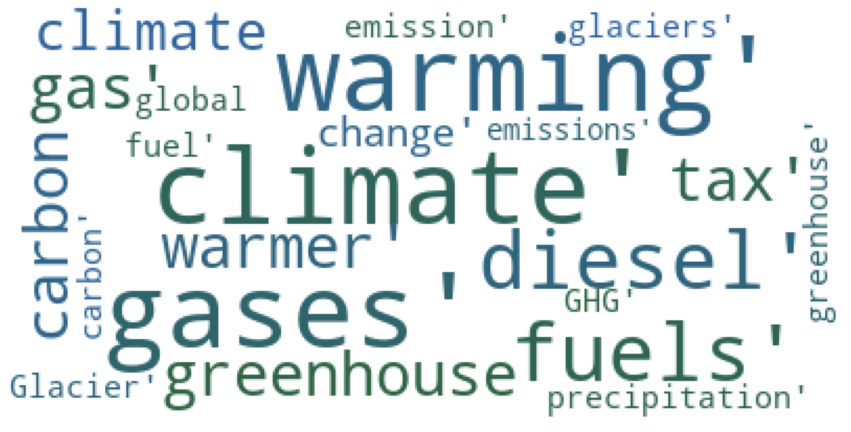

In [81]:
wordcloud = WordCloud(max_font_size=50, contour_width=3, background_color='white' ).generate(str(keywords)) #generate an image composed of the key word

# Display the generated image:
fig = plt.figure(figsize=(15,15))
plt.imshow(wordcloud.recolor(color_func = couleur))
plt.axis("off")
plt.show();

#save the figure
fig.savefig('image/key_word-wordcloud.png')

### Extracting quotes of interest

In [38]:
#method to filter our quotation from quotebank data

def chunk_filtering(chunk, lst):
    template=[] #Creation of an empty list :it's always cheaper to append to a list and create a DataFrame than append on a empty dataframe.
    
    for i in lst: 
        template.append(chunk.loc[(chunk["quotation"].apply(lambda x : i in str(x).split(' ')) )& 
                                  (chunk["speaker"].apply(lambda x: x!= "None"))&
                                  (chunk["qids"].apply(lambda x: len(np.array(x))==1))].drop(['phase', 'urls', 'probas'], axis=1))
        #Select quotations with value in speaker column different from 'None' and 
        #quotations containing the key word and drop phase, urls and probas  column. 
        #As the speaker is identified by their name and not their QID, we select the ones that have a unique QID to facilitate our analysis.
        
        
    return (pd.concat(template, ignore_index=True))# return a dataframe with our data of interest

In [39]:
dico={} #We create a dictonary to loop over our years. 
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico[date] = pd.read_json(f'data/quotes-{date}.json.bz2', lines=True, compression='bz2', chunksize=100000)

In [40]:
keywords = ['gases', 'fuels', 'diesel', 'greenhouse gases', 'gas', 'warmer',
       'carbon tax', 'climate change', 'precipitation', 'emission',
       'glaciers', 'GHG', 'global warming', 'greenhouse', 
       'Glacier', 'warming', 'fuel', 'carbon', 'climate', 'Climate',
       'emissions']


for date, df in dico.items() : 
    
    for i, chunk in enumerate(df) : 
        chunk_clean=chunk_filtering(chunk, keywords) #recover interested row of the chunk
        header = i == 0 #we kept the name of the column only for the first chunk
        mode = 'w' if i == 0 else 'a' # For appending data to an existing CSV file (so for every chunk exepct the first one), 
                                        #we can use mode = a
        chunk_clean.to_csv(path_or_buf=f"data/clean_quotes-{date}.bz2",compression='bz2',header=header, mode=mode, index = False ) #Load to CSV.    
        

> #### *Recovering of our clean quotes*

In [14]:
dico_clean={} #dictionnary that associate date and the related clean quotes
length = 0

for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    clean = pd.read_csv(f'data/clean_quotes-{date}.bz2', compression='bz2')
    clean.drop_duplicates(subset=['quotation'], inplace= True) #make sure there's no duplicate
    dico_clean[date]=clean #add to the dico
    length += len(dico_clean[date]) #The length is used here to obtain the total number of quotes. 

In [15]:
print("At result, we extracted {} quotes frome quotebank data".format(length))

At result, we extracted 292820 quotes frome quotebank data


## Speakers Data

### Extracting labels QIDs

The provided speaker_attributes.parquet file contains attributes in terms of QIDs, thereby being uninterpretable by humans (df_qid).
To map the QIDs to meaningful labels, we used the provided wikidata_labels_descriptions_quotebank.csv.bz2 (https://drive.google.com/drive/u/0/folders/1VAFHacZFh0oxSxilgNByb1nlNsqznUf0) containing the label and value for the respective QID containing the df_qid (df_label_qid).
By combining the information of both we can obtained usefull information about speakers.

> ####  *Load parquet file*

In [29]:
#Loading our speakers attribute dataset, and the dataset necessary to interpret our QIDs.
df_qid = pd.read_parquet("speaker_attributes.parquet",engine= "pyarrow" )
df_label_qid = pd.read_csv('data/wikidata_labels_descriptions_quotebank.csv.bz2',index_col='QID')

> #### *Some visualization and sort of the parquet file*

In [30]:
df_qid.id.is_unique #verify is QID is unique

True

In [31]:
df_qid.head(3)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None


Let's verify that academic_degree has revelant values.

In [32]:
print("There's no academic degree revelant value ? {}".format(all(df_qid.academic_degree.isna())))

There's no academic degree revelant value ? False


It seems that academic degree values are revelant, we decided to drop lastrevid, US_congress_bio_ID, type, Alisiase as they will not be used in our project.

In [33]:
df_qid.drop(['lastrevid', 'US_congress_bio_ID', 'type', 'aliases'], axis=1, inplace=True)

> #### *Transformation of the df_qid with the label value from df_label_qid*

In [34]:
#We found that one of the QID was deleted from Wikidata. We will start by dropping this value, so that it does not distrurb our labelling. 

def transform(y):
    if y is None: return None
    x = set(y)
    x.discard("Q99753484")
    return np.array(list(x))
    
df_qid['occupation']=df_qid['occupation'].apply(lambda y : transform(y))

In [35]:
#We found out that some of the QIDs used in the speaker attribute file are actually redirection from an original QID. 
#We will manulally add their corresponding information using the orginal QID. We found the corespondance manualy between the two. 
#Here, there are in order, respectively the redirection QID, and its corresponding original one. One of he QID was only present 
#as a redirection, so we manually added this one (Q3186984), and its corresponding info. 

redirect_QID=['Q3268166', 'Q11815360', 'Q12014399', 'Q16287483',
              'Q20432251', 'Q21550646', 'Q13365117', 'Q13424794',
             'Q1248362', 'Q6859927', 'Q15145782',
             'Q15991263', 'Q12455619', 'Q5568256', 
             'Q6363085', 'Q11819457', 'Q12334852', 'Q15145783']
actual_QID=['Q1113899', 'Q1919436', 'Q250867', 'Q6051619',
             'Q26934816', 'Q18431816', 'Q12840545', 'Q5157338',
            'Q3455803', 'Q715222', 'Q1052281',
            'Q2743689', 'Q7019111', 'Q3738699', 
            'Q380075', 'Q3391743', 'Q476246', 'Q2449503']


lst=[['Journalist', 'monthly magazine of the United Kingdom‘s National Union of Journalists (NUJ)']]
indexes=['Q3186984']
col=['Label', 'Description']
for i in range(len(redirect_QID)):
    lst.append([df_label_qid.loc[actual_QID[i]]['Label'], 
                df_label_qid.loc[actual_QID[i]]['Description']])
    indexes.append(redirect_QID[i])

additional_df= pd.DataFrame(lst, columns= col, index=indexes)
df_label=df_label_qid.append(additional_df, ignore_index= False)

In [36]:
#Applying the function to every column containing QIDs. 
cols=['nationality', 'gender', 'ethnic_group','occupation', 'party', 'academic_degree', 'candidacy', 'religion'] #List of columns 
#containing QID to be replace

df_qid[cols] = df_qid[cols].applymap(lambda d: d if d is not None else []) #Replacing every None value with an empty list for futur analysis.
df_qid[cols] = df_qid[cols].applymap(lambda y: [df_label.loc[Q].Label for Q in y]) #Replacing QIDs with their corresponding label.

### Extracting labels climate

Now, we wanted to see which speakers said quotes that we considered as climate-related. We matched speakers from the df_qid with a value climate : we selected every QIDs that appears in our list of climate-related-quotes and they have been assigned a value of 1 in the new climate column.

> #### *Qid_climate list*

In [37]:
qid_climate=[]

#iteration in the dico_clean containing extracted files for climate involved quotes
for key, file in dico_clean.items() :
    qid_climate.append(file.drop_duplicates(['qids'], keep='first')['qids'].map(lambda y : ast.literal_eval(y)[0]).tolist()) #add unique QIDs from each file
    
qid_climate=set(item for sublist in qid_climate for item in sublist)#create a set with unique QIDs from each year/file.

In [38]:
print("We extracted {} QIDs related to speakers talking about climate.".format(len(qid_climate)))

We extracted 63645 QIDs related to speakers talking about climate.


> #### *Add an additional column to df_qid*

In [39]:
df_qid['climate']=0 #create a column named climate with value equals 0
df_qid.loc[df_qid[pd.Index(df_qid.id.isin(pd.Index(qid_climate)))].index, 'climate']=1 #replace with 1 for speakers that appear in the climate-involved quotes.

In [40]:
df_qid.sample(10)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate
6924792,[+1889-03-08T00:00:00Z],"[India, British India, Dominion of India]",[male],[],[politician],[],[],Q4918639,Biswanath Das,[],[],0
605001,[+1917-01-01T00:00:00Z],[],[],[],[painter],[],[],Q60694127,None,[],[],0
7752530,None,[],[female],[],[],[],[],Q95733423,Deborah Huss,[],[],0
5436703,None,[],[male],[],[computer scientist],[],[],Q93384213,Gilbert Cockton,[],[],0
6507041,None,[],[female],[],[researcher],[],[],Q89858232,Lisa J Cameron,[],[],0
2695098,[+1954-01-01T00:00:00Z],[Australia],[male],[],[judoka],[],[],Q29959515,Mark Carew,[],[],0
6868866,[+1140-00-00T00:00:00Z],[],[male],[],"[Catholic priest, diplomat]",[],[],Q2585178,Niccolò de Romanis,[],[Christianity],0
5989592,[+1920-02-07T00:00:00Z],[Russia],[male],[],[],[],[],Q18239252,None,[],[],0
2289530,[+1898-07-02T00:00:00Z],[Poland],[female],[],"[film actor, actor, film director, theater dir...",[],[],Q608249,Stanisława Perzanowska,[],[],0
4631349,[+1853-05-01T00:00:00Z],[Switzerland],[male],[],"[architect, urban planner]",[],[],Q3629637,Augusto Guidini,[],[],0


### Speakers Filtering

As a good data scientist, the first thing to do is to clean up the data. In order to do that, we first checked for missing rows. Then we replaced the date of birth by the year of birth and filter our speakers in order to keep only the ones whose age is bewteen 12 and 100 . Indeed, as climate change is a relatively new topic, and we do not consider quotes from speakers that are younger then 12 years old.

In [41]:
speakers=df_qid.copy()

In [42]:
speakers.sample(3)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate
5352401,None,[],[],[],[researcher],[],[],Q88455552,Stephanie A Eyerly-Webb,[],[],0
8208492,[+1916-03-02T00:00:00Z],"[United Kingdom, United Kingdom of Great Brita...",[male],[],[writer],[],[],Q15452448,John Lodwick,[],[],0
5927410,[+1916-05-20T00:00:00Z],[Romania],[male],[],[physician],[],[],Q12727723,Ermil Nichifor,[],[],0


In [43]:
print("Is there some missing rows ? {} ".format(np.array([speakers.drop(columns=['label', 'id']).isnull().any(axis=1)]).all()))

Is there some missing rows ? False 


> #### *filtering of ages*

In [44]:
speakers.date_of_birth=speakers.fillna(0).date_of_birth.map(lambda y : str(y).split("-")[0][3:])#Keep only the year of birth.
speakers=speakers.loc[speakers['date_of_birth'].apply(lambda x: x!= '' and int(x)>1920 and int(x)< 2008)]#Keep only speakers born between  2008. and 1920.
speakers['date_of_birth']=speakers['date_of_birth'].astype(int) #conversion to int

In [45]:
speakers.sample(3)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate
6660885,1959,[Norway],[male],[],[swimmer],[],[],Q97695026,Tom Walle,[],[],0
6962482,1970,[United States of America],[male],[],"[association football manager, association foo...",[],[],Q6173347,Jeff Betts,[],[],0
8946773,1950,[],[],[],[visual artist],[],[],Q99477075,Jean Christophe Pratt,[],[],0


### One Hot Encoding

As we can see speakers dataframe is mainly composed of categorical variables meaning that the first think to do before making any machine learning algortihms is to prepararing our data and do some features engeenring in order to improve our prediction. In our case, we decided to perfome a one hot encoding of our variables. It is a process in which we convert the categorical variable into a new categorial column and assign 0 or 1.

First, let's check the number of categories we get per characteristic

In [32]:
columns_eval = ['occupation','religion','nationality','ethnic_group','party','academic_degree', 'gender'] #select our columns of interest

In [69]:
for column in columns_eval : 
    print(f'For the variable {column} we observed {len(speakers[column].explode().value_counts())} differents categories')

For the variable occupation we observed 7973 differents categories
For the variable religion we observed 582 differents categories
For the variable nationality we observed 1026 differents categories
For the variable ethnic_group we observed 1467 differents categories
For the variable party we observed 5628 differents categories
For the variable academic_degree we observed 813 differents categories
For the variable gender we observed 30 differents categories


The objective of this project is to visualize the **typical** profiles of people who talk about climate in the media, so we assumed that the 20 most frequent categories in each feature are sufficient to describe these types of profiles. Consequently, we made one hot encoding on the selected categories and used it to make our classification.  We are aware that this pre-selection induces bias in our model, but given that we wish to analyze the media's view of climate in general, selecting the group of characteristics mainly interviewed in the media seems relevant.

In [37]:
#functions to create categorical columns 1-if the persone has this feature and 0 if not
def one_hot(list, column):
    for o in list: #iterating over the list . 
        speakers[f'{o}'] = 0 
        speakers.loc[speakers[column].apply(lambda value : o in value), f'{o}'] = 1  

In [38]:
#use of the function one_hot to keep our categorical data of interest
for column in columns_eval : 
    subdata=speakers[column].explode().value_counts()
    one_hot(subdata.index.tolist()[0:20], column)

In [39]:
speakers.sample(3)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,...,cisgender male,agender,male organism,two-spirit,bigender,transmasculine,neutral sex,X-gender,third gender,muxe
1146504,1946,[Yemen],[male],[],"[politician, diplomat]",[General People's Congress],[],Q307338,Abdul Qadir Bajamal,[],...,0,0,0,0,0,0,0,0,0,0
7961803,1995,[United States of America],[male],[],[racing automobile driver],[],[],Q1094245,Chase Elliott,[],...,0,0,0,0,0,0,0,0,0,0
4906105,1989,[],[male],[],[volleyball player],[],[],Q22003052,Mohamed Al-Oui,[],...,0,0,0,0,0,0,0,0,0,0


We remove the orignial feature column and only keep columns revelant for our classification. 

> #### *Loading of the one_hot encoding dataFrame*

In [40]:
speakers.drop(['occupation', 'religion', 'nationality', 
               'ethnic_group', 'party', 'academic_degree', 'id', 'candidacy', 'gender'], axis=1).to_csv('data/one_hot.bz2', compression = 'bz2', index=False)

# Visualisation

Now we recovered our data, we can start to look more closely at them  ! First, let's see the distirbution of the quotes categorize as climate and them the one of our speakers.

## Quotation Distribution
### *Is there any temporal evolution in the mediatic coverage of the climate crisis ?*

Climate is an increasingly emerging topic in society, as we extracted quotation from the last six years, let's see if the media reflects this trend.

>#### *Transfrom the Date of our quotes*

In [55]:
tmp=[]

for years, quotes in dico_clean.items() : 
    tmp.append(quotes) #concatenate quotation from every year

quotes = pd.concat(tmp) #transfrom to Dataframe containg all quotation from every year.

In [56]:
quotes.date.map(lambda y : datetime.strptime(y, '%Y-%m-%d %H:%M:%S')) #transform date value to a datetime object
quotes.sort_values(by='date', inplace=True) #sort the date

In [57]:
quotes.sample(3)

,quoteID,quotation,speaker,qids,date,numOccurrences
4977,2016-07-26-080991,Our state has a very strong plumbing and gas i...,Mick de Brenni,['Q18977905'],2016-07-26 14:00:00,4
27799,2015-09-30-037358,I had several unsuccessful attempts. I didn't ...,Roger Austin,['Q7357814'],2015-09-30 07:00:00,1
21392,2016-02-15-104438,"we do see going forward, a paradigm shift, a t...",Piyush Goyal,['Q7199798'],2016-02-15 08:41:25,2


==> Now, let's see the repartition of our quotes **monthly increments** and then  **yearly slices**.

### Per month

In [127]:
quotes['date'] = pd.to_datetime(quotes['date']).dt.strftime('%Y-%m') #change the format of the year to Year-Month

<Figure size 1080x1080 with 0 Axes>

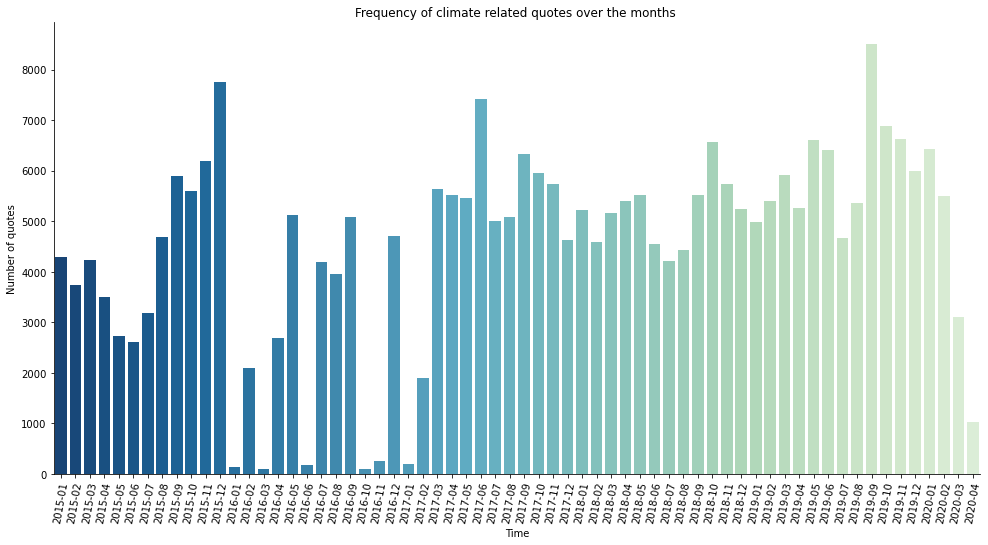

In [27]:
#initialize color palette
palette = sns.color_palette("GnBu", n_colors=76)
palette.reverse()


#plot the figure
fig = plt.figure(figsize=(15,15))
fig=sns.catplot(data=quotes, x = 'date',  kind="count", 
               palette=palette,height=7, aspect=2)


#plot parameters settings 
fig.set_xticklabels(rotation=80)


fig.set(xlabel='Time', ylabel='Number of quotes',
       title= 'Frequency of climate related quotes over the months ') #We chose a log scale for better data visulalisation. 



sns.despine()
#save the figure
fig.savefig('image/temporal_per_month.png')

plt.show()

#### *Interpretation* : 
First of all, we can see an increase of the number of climate-related quotes in 2015. Especially, we can see a spike in December, corresponding to the The Paris Agreement. The very limited number of climate-related quotes in 2016 could be explained by two things. First, the QuoteBank dataset for 2016 was small compared to the one for other complete years (it seems to be the case, at least for the months showing a very low number of quotes). On another hand, 2016 was election year in the United States. This means that the mediatic place was majoritarly occupied by political concerns in the USA, letting less space for climate-change discussions. Then, from 2017,to 2020, we can se a slow increase in the number of quotes. In order to show this better, we will plot the distribution over years. As we can see, the data for 2020 stops in April. 
We will now try to match the observed spkies with climate-related events.
- December 2015: The Paris Agreement (source: https://unfccc.int/fr/processus-et-reunions/l-accord-de-paris/l-accord-de-paris)
- June 2017: World Environment Day 2017 (source: https://www.dffe.gov.za/event/international/worldenvironmentday2017)
- October 2018: WHO’s First Global Conference on Air Pollution and Health (source: https://www.who.int/news-room/events/detail/2018/10/30/default-calendar/who-s-first-global-conference-on-air-pollution-and-health)
- August 2019: Climate was assigned as goal of the month by UN (source: https://www.un.org/sustainabledevelopment/goal-of-the-month-archive/goal-of-the-month-august-2019-climate/)

### Per Year

In [128]:
quotes['date'] = pd.to_datetime(quotes['date']).dt.strftime('%Y') #change the format of the year to Year

<Figure size 1080x1080 with 0 Axes>

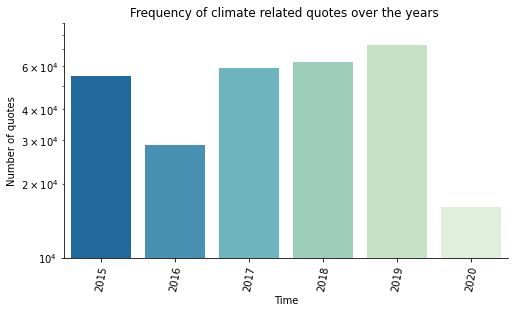

In [ ]:
palette = sns.color_palette("GnBu", n_colors=6)
palette.reverse()

fig = plt.figure(figsize=(15,15))
fig=sns.catplot(data=quotes, x = 'date',  kind="count", 
               palette=palette,height=4, aspect=1.8)



fig.set_xticklabels(rotation=80)
plt.ylim(1e4, 9e4)

fig.set(xlabel='Time', ylabel='Number of quotes', 
       title= 'Frequency of climate related quotes over the years ', yscale='log') #We chose a log scale for better data visulalisation. 

sns.despine()
fig.savefig('image/temporal_per_year.png')
plt.show()

### General Interpretation 
We can see that from 2015 to 2019 the number of quotes that talk about climate have been rising, except for the year 2016 and 2020. This rise is explained by the fact that we are more and more aware about climate change due in particluar to the huge mobiblization of the younger generation. Indeed, at only 15 years old Greta Thunberg became the leader of an ecologist movement during the summer 2018 and her reputation has not stopped growing since. We still observe a smaller number of quotes in 2016, which once again could be explained by the Quotebank data set itself, or the american election, or even a combination of both. 

## Speakers Distribution

### *What are the main typical profiles of people talking about climate in the media ? Who in the media represent the most this subject over time ?*

In [ ]:
print('There is {} speakers of which {} are interested in climate.'.format(len(speakers),len(speakers[speakers['climate']==1]) ))

There is 2895036 speakers of which 48722 are interested in climate.


As can be seen, we recover a huge number of speakers not associated with climate. Therefore, as a first analysis it would be interesting to observe the distribution of the main features among the speakers independently of their interest in climate and then compare them with those of the climate-related speakers. 

### Mixed Speakers

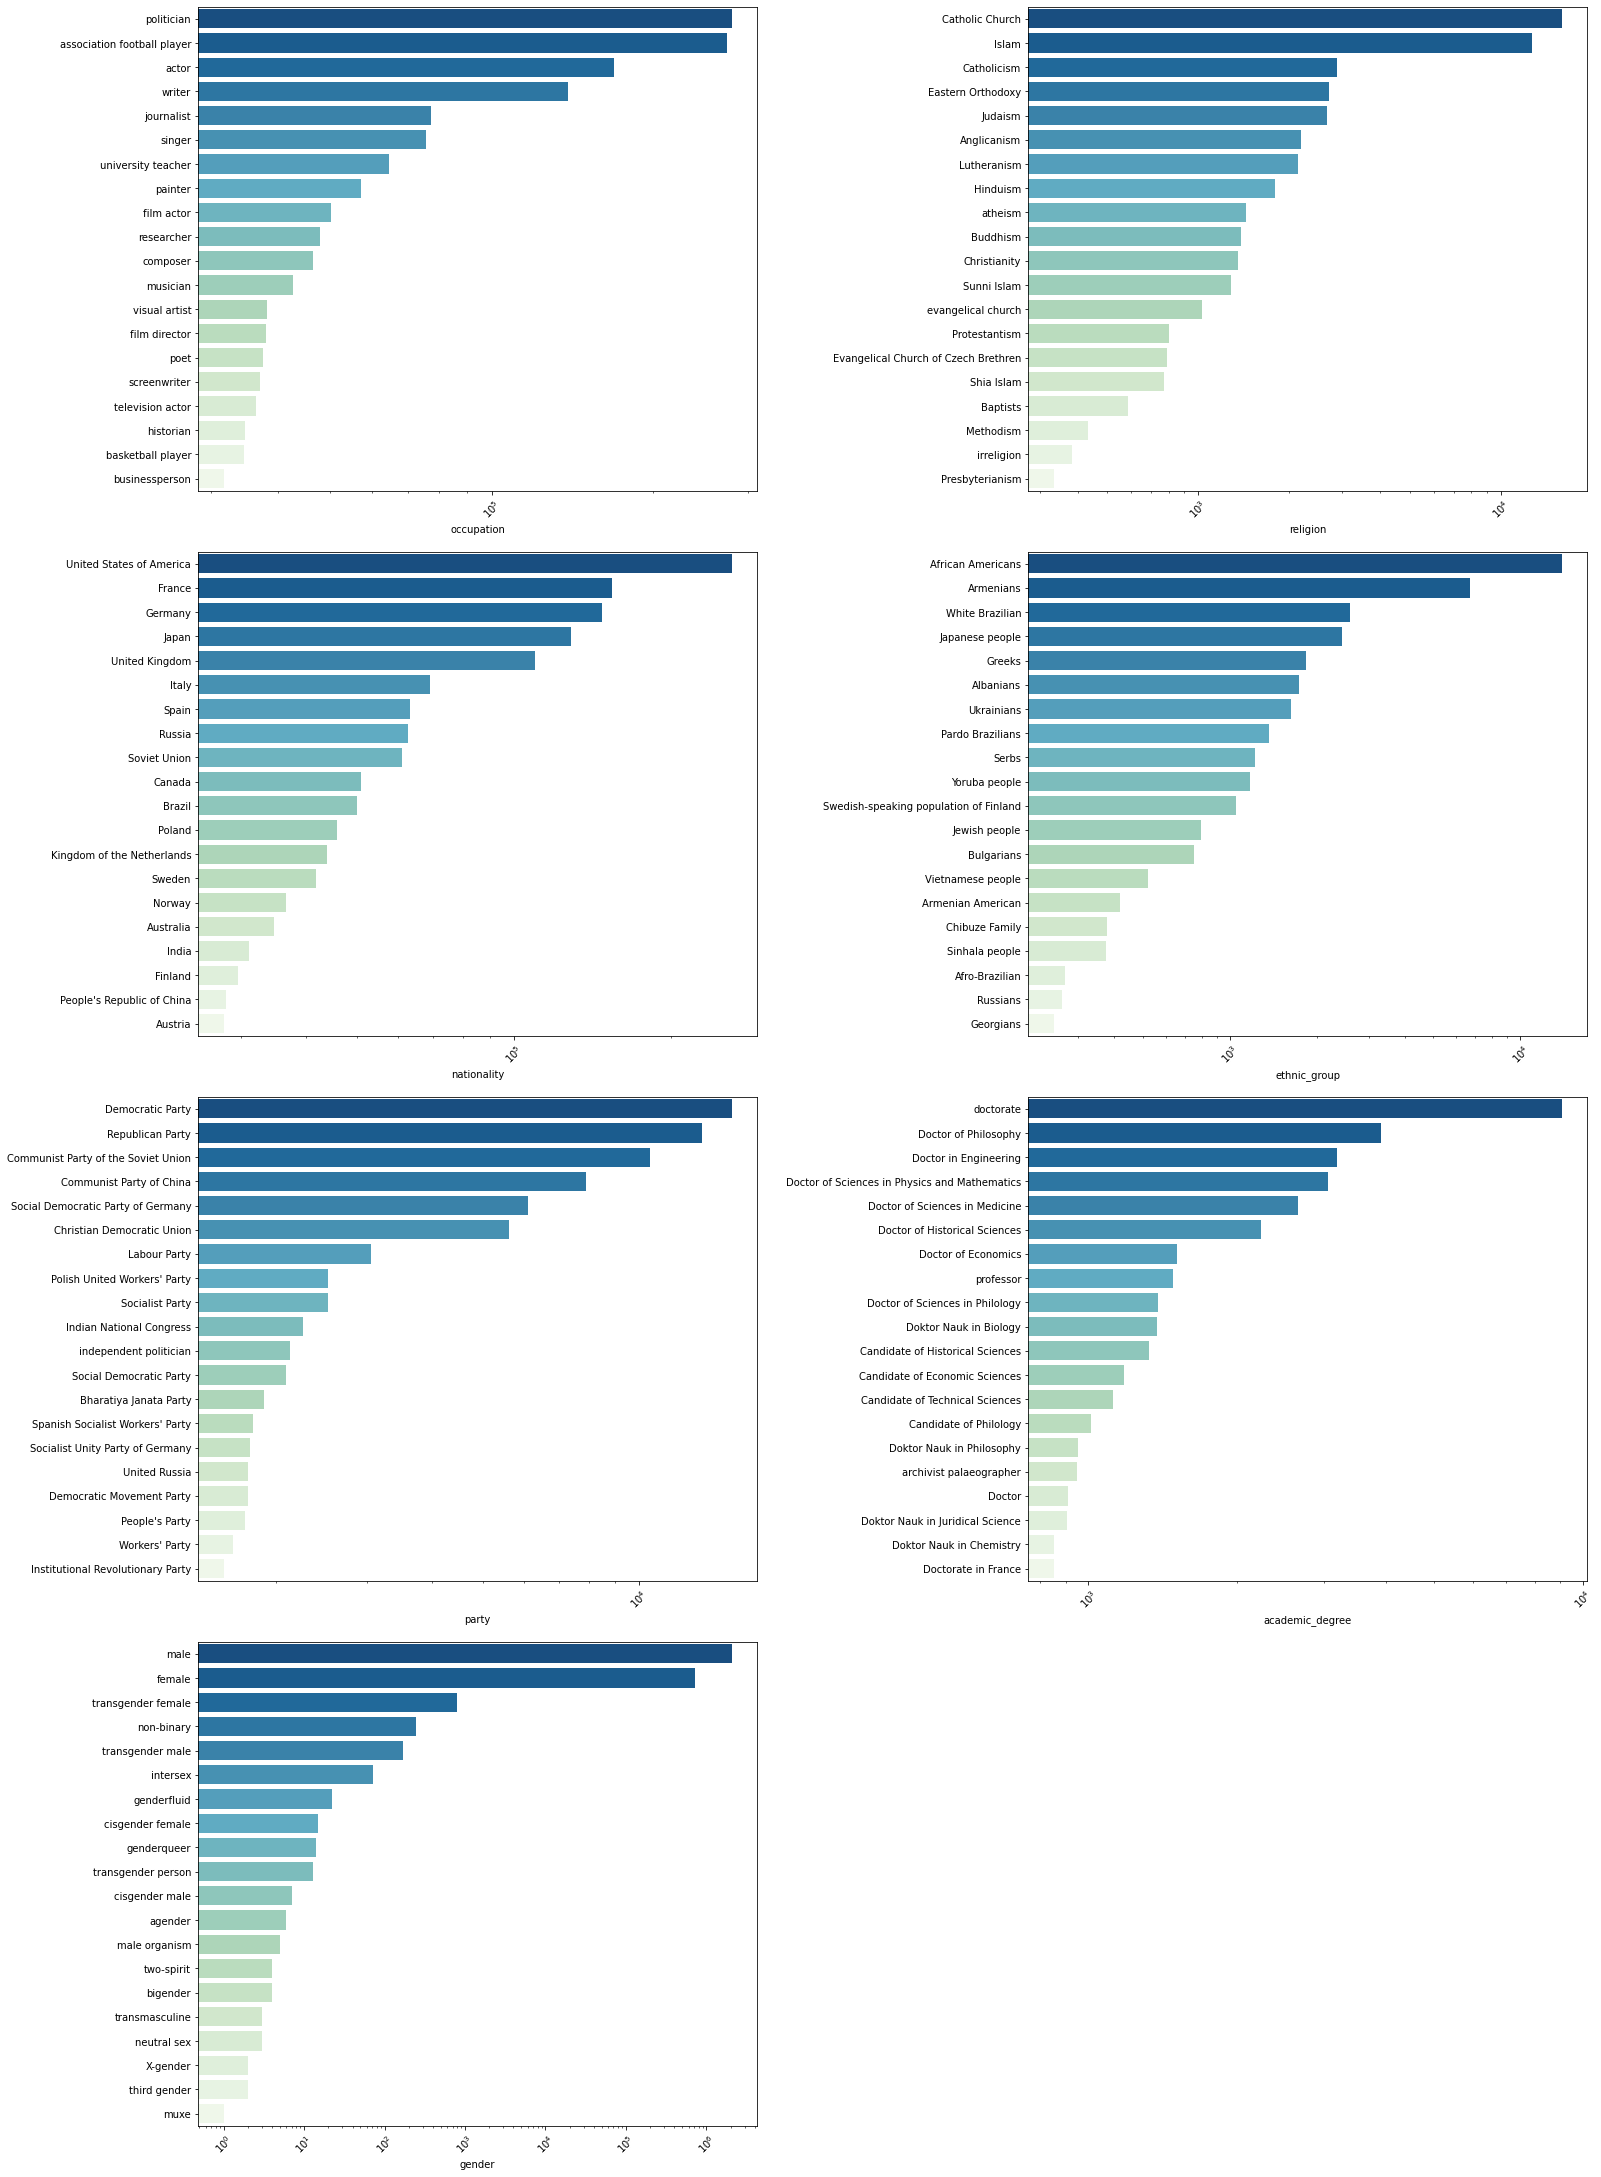

In [34]:
index = [[0,0],[0,1],[1,0],[1,1], [2,0], [2,1], [3,0]]

fig, axs = plt.subplots(4,2, figsize=(20,30))
fig.delaxes(axs[3, 1]) #The indexing is zero - based here
fig.tight_layout(pad=1, w_pad = 24, h_pad = 4)

palette = sns.color_palette("GnBu", n_colors=20)
palette.reverse()


for idx, column in enumerate(columns_eval): 
    
    
    
    subdata=speakers[column].explode().value_counts()
    sns.barplot(y= subdata.head(20).index, x = subdata.head(20), ax = axs[index[idx][0]][index[idx][1]], palette =palette)
    axs[index[idx][0]][index[idx][1]].tick_params(labelrotation=45, axis='x')
    axs[index[idx][0]][index[idx][1]].set(xscale='log')
    
    
    

plt.show()
fig.savefig('image/mixed_features.png')

#### *Interpretation* : 

Above are represented the main characteristics of the people appearing in Quotebank. When looking at the prinicpal occupations, we see that most of them are politician, actors, writer, journalist. A suprising fact is that football player are extremely represented in the media. We will have to keep this in mind while analyzing the climate-change-involved speakers. Another thing that we should emphasize is that it seems that most speaker appearing in the Quotebank are highly educated (Doctorate).  When having a closer look at the scales, we see that the information about academic degree is quite sparse, meaning there are lot of speakers for which we do not know how educated they are . Concerning the ethnic group, we see  African American that at the top, but it seems to be cause by the fact that it is not specified for most White people in the Wikidata. As we have only sparse information about these characteristics, it will be difficult to draw conclusion from them. We will now use these information to analyze the speakers that are involved in climate. 

### Climate Speakers

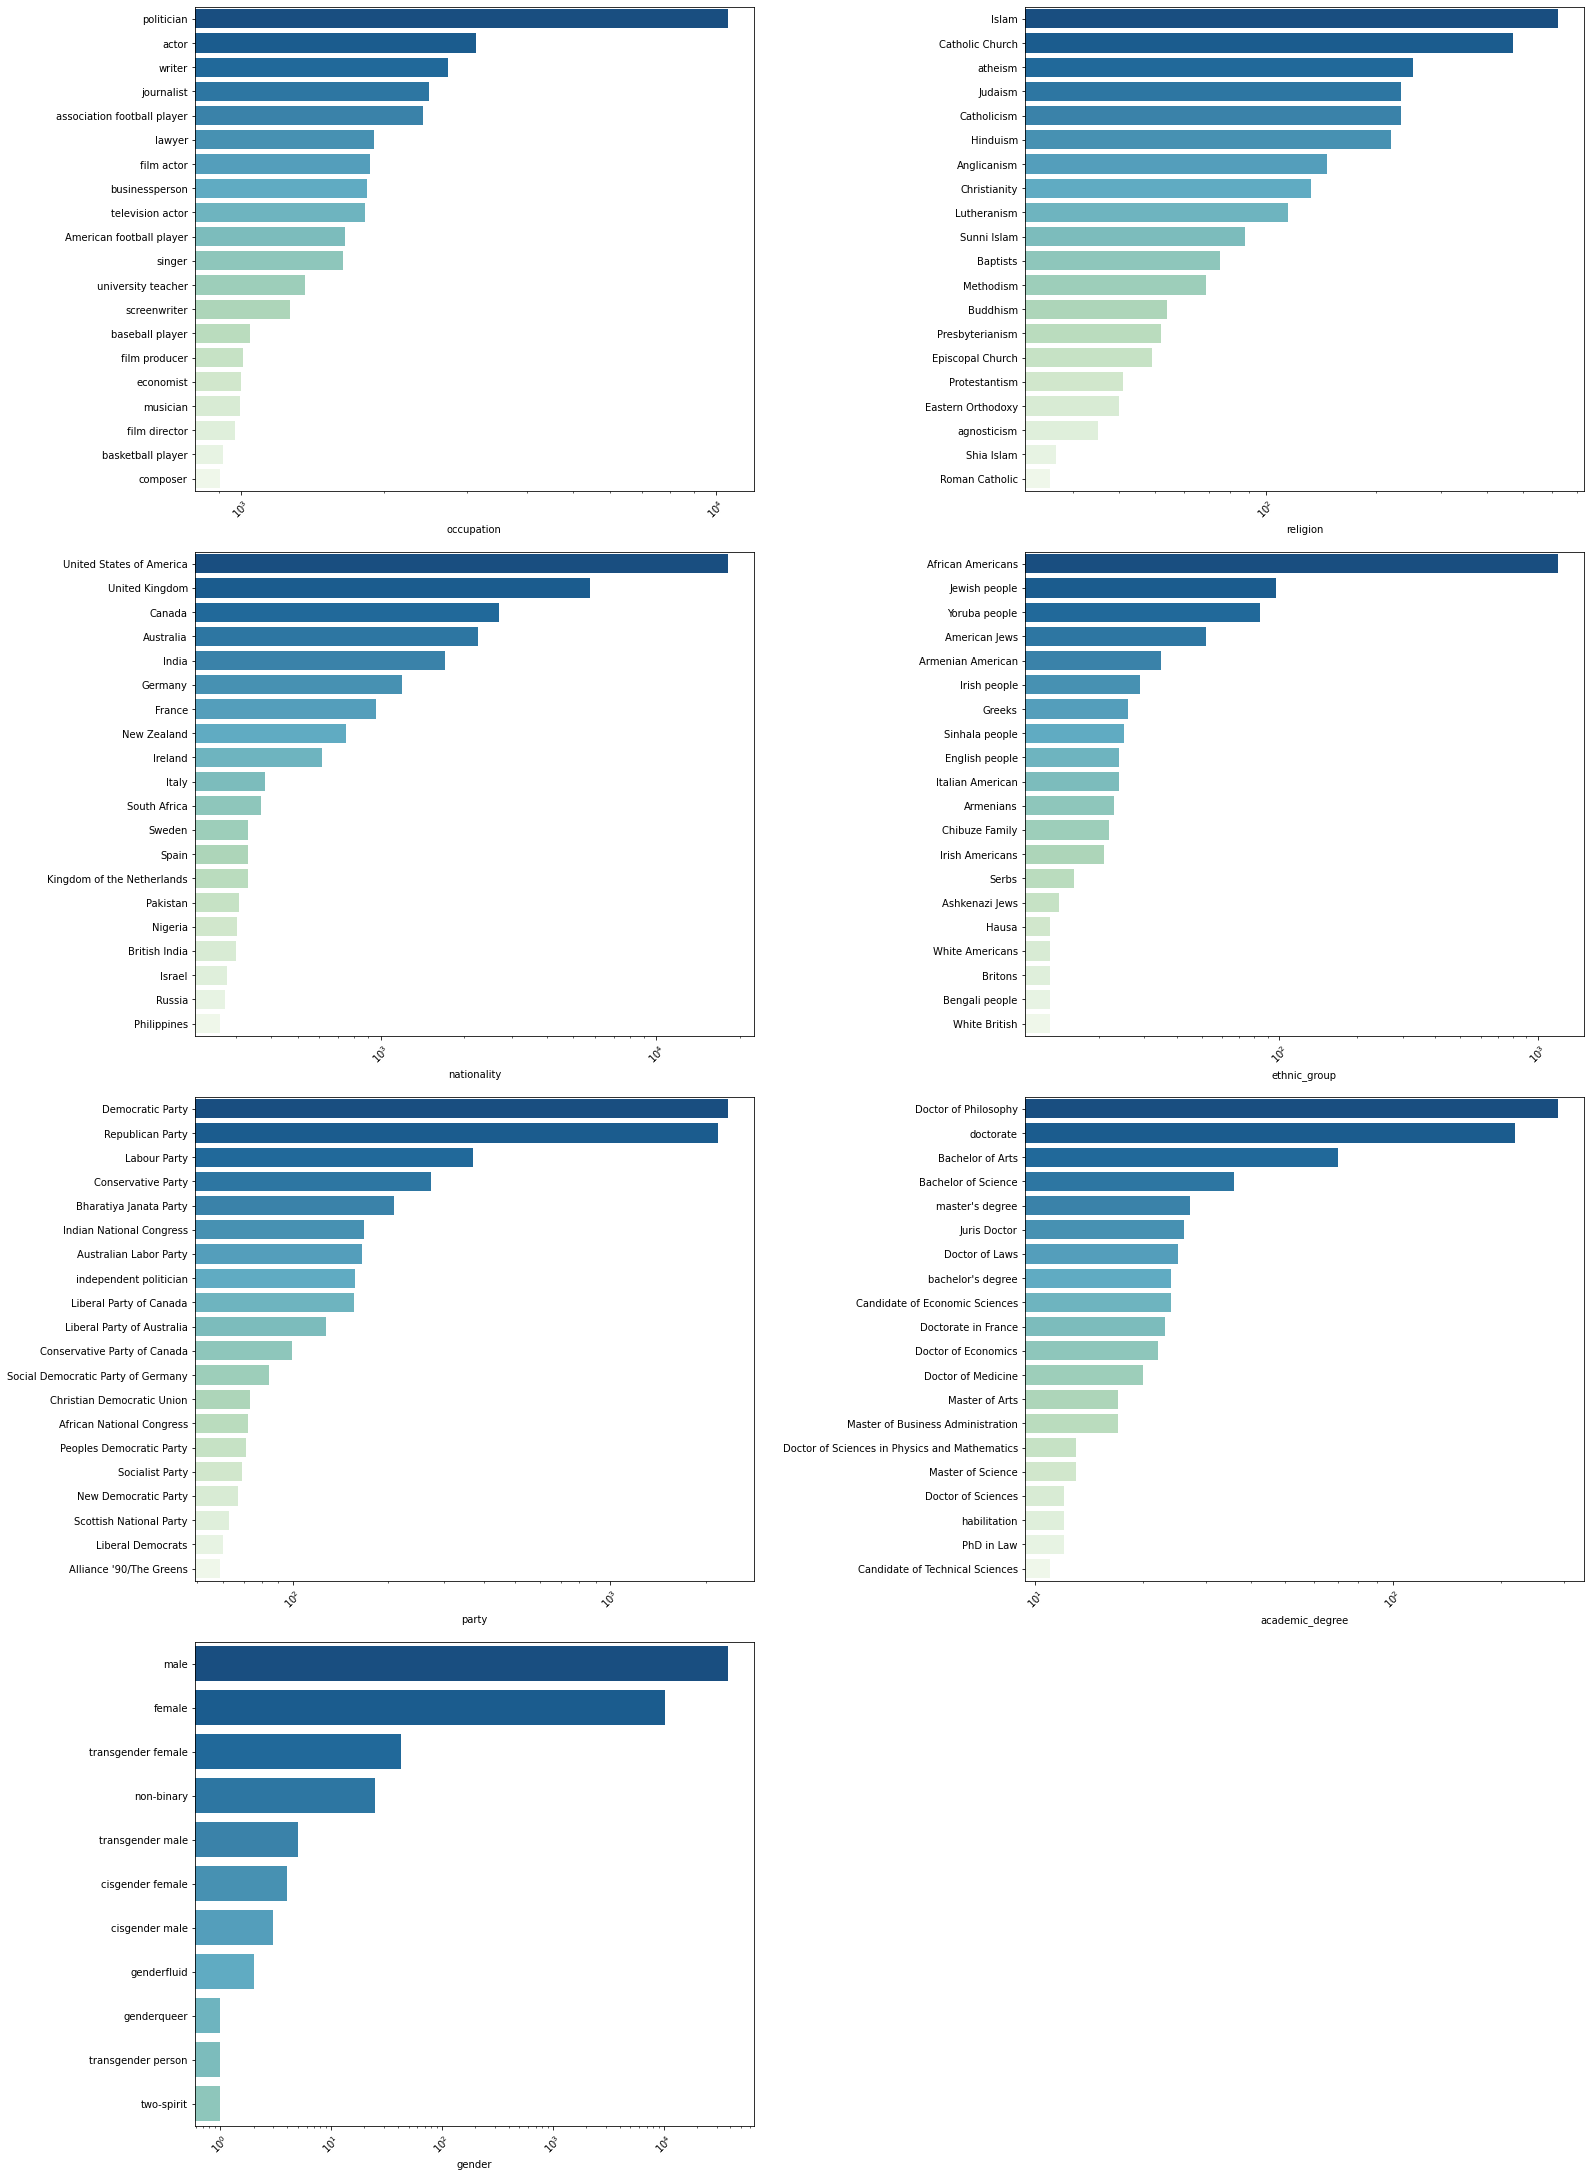

In [35]:
climate = speakers[speakers['climate']==1]
index = [[0,0],[0,1],[1,0],[1,1], [2,0], [2,1], [3,0]]


fig, axs = plt.subplots(4,2, figsize=(20,30))
fig.delaxes(axs[3, 1]) #The indexing is zero - based here
fig.tight_layout(pad=1, w_pad = 24, h_pad = 4)


for idx, column in enumerate(columns_eval): 
    
    subdata=climate[column].explode().value_counts()
    sns.barplot(y= subdata.head(20).index, x = subdata.head(20), ax = axs[index[idx][0]][index[idx][1]], palette =palette)
    axs[index[idx][0]][index[idx][1]].tick_params(labelrotation=45, axis='x')
    axs[index[idx][0]][index[idx][1]].set(xscale='log')
    axs[index[idx][0]][index[idx][1]].figure.savefig(f'image/speakers_climate_{column}.png')

plt.show()
fig.savefig('image/speakers_features.png')

### General Interpretation 

In order to analyze the distributions of characteristics for the climate-involved speakers, we have to compare them to the ones of the general speakers. One thing we notice is the apparition of a polical party focused majoritarily on environmental concern: The Greens. Another thing we can note is the change in distribution for the occupation. We can see that the most represented professions are quite similar to the ones for the general speakers. An exception is that football player are less present in the climate-involved people. A critical thing to amphesize is that there are very little number of scientists, researchers or activits in the mediated climate-involved speakers. Rather than showing that they are not vocal about this issue, it rathers points out that the mediatic place seems to be monopolized by politics and celebrities (actors). This should be nuanced as we are looking at the speakers without considering how much they actually talk about climate in the media. We will now focus on the people that talk the most about climate. 

### Top Speakers

Now we would like to observe by which people the climate is represented in the media over the year : based on the number of occurence from the quotes data, we extracted the QIDs of the **10 people with the highest number of occurrences over the year** allowing us to get their characteristic. Then, we compared the mediatic importance of first one of each year and their evolution.

In [36]:
climate = climate.set_index('id') #re-index according qids in the speakers dataframe

> #### *Recover number of occurences per year of each speakers* 

In [37]:
for key,value in dico_clean.items(): 
    
    
    df = value.groupby('qids').sum() #group the qids together and sum Number of occurence ()
    df.index= df.index.map(lambda x: literal_eval(x)[0]) #adapt the type of the Qid to match with the one of climate 
    df = df.rename(columns={'numOccurrences': str(key)}) #rename with the year
    
    climate=climate.join(df) #join the df componsed of the number of occurences per year

In [45]:
climate.sample(2)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,candidacy,religion,climate,2020,2019,2018,2017,2016,2015,Total
id,,,,,,,,,,,,,,,,,,
Q20981236,1941,[],[male],[],[painter],[],[],Malcolm Dickson,[],[],1,0,0,0,0,0,1,1
Q7384239,1987,[United States of America],[male],[],"[actor, television actor]",[],[],Ryan Lane,[],[],1,0,0,0,2,0,0,2


In [39]:
climate = climate.fillna(0) 
climate[['2020','2019','2018','2017','2016','2015']]=climate[['2020','2019','2018', '2017', '2016', '2015']].astype(int) #convert to int 

> #### *Recover the total number of occurences of each speakers* 

In [40]:
climate['Total']=climate[['2020','2019','2018','2017','2016','2015']].sum(axis=1) #sum all the occurences overt the year

In [44]:
climate.sample(2)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,candidacy,religion,climate,2020,2019,2018,2017,2016,2015,Total
id,,,,,,,,,,,,,,,,,,
Q688518,1949,[Austria],[male],[],"[politician, entrepreneur]",[Austrian People's Party],[doctorate],Christoph Leitl,[],[],1,0,2,1,0,0,0,3
Q2400916,1968,[United States of America],[male],[],"[singer, songwriter]",[],[],Christopher Barron Gross,[],[],1,0,2,8,4,2,1,17


>#### *Recover the Top 10*

In [42]:
top_10 = {}  #empty dictionnary

for year in ['2015', '2016', '2017', '2018', '2019', '2020'] :
    cols=['date_of_birth', 'nationality', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'label', 'candidacy', 'religion', year]  #name of target column
    top_10[year]=climate[cols].sort_values(by=[year], inplace=False, ascending=False).head(10)#add to the disctionnary the top speakers and their characteristic

In [43]:
top_10['2015'].sample(2)

,date_of_birth,nationality,ethnic_group,occupation,party,academic_degree,label,candidacy,religion,2015
id,,,,,,,,,,
Q76,1961,[United States of America],"[African Americans, Multiracial American, Luo ...","[community organizer, politician, lawyer, poli...",[Democratic Party],"[Bachelor of Arts, Juris Doctor]",Barack Obama,[2004 United States Senate election in Illinoi...,"[Protestantism, congregational church, Congreg...",15034
Q1253,1944,[South Korea],[Koreans],"[politician, diplomat]",[independent politician],[],Ban Ki-moon,[],"[Confucianism, Buddhism]",2966


> #### *Plot characteristic of the top 10 speakers*

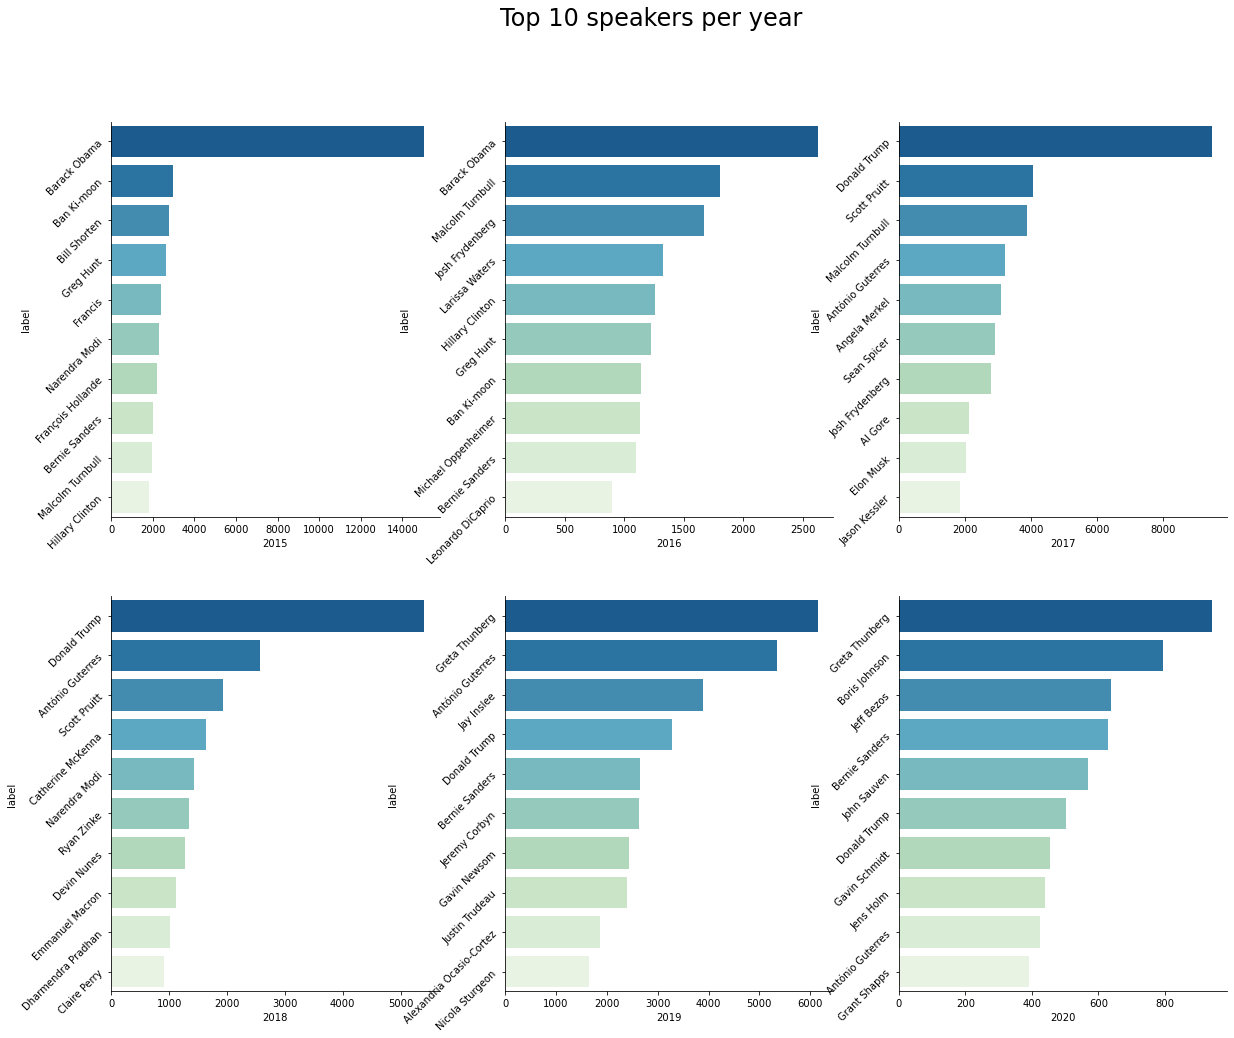

In [46]:
fig, axes = plt.subplots(2,3, figsize=(20,16)) #Creating the figure with the desired number of subplots.
fig.suptitle ('Top 10 speakers per year', 
              fontsize= 24)


palette = sns.color_palette("GnBu", n_colors=10)
palette.reverse()

#Creating a dictionary with plot parameters for every distribution: the subplot, if the element 
#is discrete or not, and the number of bins.  
fig_dic= {'2015': [axes[0,0]], 
          '2016': [axes[0,1]], 
          '2017':[axes[0,2]],
          '2018': [axes[1,0]], 
          '2019': [axes[1,1]], 
          '2020': [axes[1,2]],

         }
for key, value in fig_dic.items():
    sns.barplot(data=top_10[key], x=key, y='label',
             ax=value[0], palette=palette
                )
   
    value[0].tick_params(labelrotation=45, axis='y')
    sns.despine()
plt.show()
fig.savefig('image/top10.png')

#### *Interpration* : 

> #### *Top 3 of speakers*

In [49]:
top_speakers=['Barack Obama', 'Donald Trump', 'Greta Thunberg']

template=[]
for speaker in top_speakers:
    template.append(climate.loc[(climate["label"].apply(lambda x : speaker == str(x)))]) #recover the speakers of interest
df_top_speakers = pd.concat(template, ignore_index=False)
df_top_speakers.index=df_top_speakers.label #re-indexing the dataframe

In [50]:
df_top_speakers.sample(2)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,candidacy,religion,climate,2020,2019,2018,2017,2016,2015,Total
label,,,,,,,,,,,,,,,,,,
Barack Obama,1961,[United States of America],[male],"[African Americans, Multiracial American, Luo ...","[community organizer, politician, lawyer, poli...",[Democratic Party],"[Bachelor of Arts, Juris Doctor]",Barack Obama,[2004 United States Senate election in Illinoi...,"[Protestantism, congregational church, Congreg...",1,174,1295,328,1598,2627,15034,21056
Donald Trump,1946,[United States of America],[male],[],"[businessperson, actor, business magnate, non-...","[Republican Party, Independence Party of Ameri...",[Bachelor of Science],Donald Trump,"[2016 United States presidential election, 202...",[Presbyterianism],1,504,3276,5403,9470,788,84,19525


In [51]:
df_top_speakers = df_top_speakers[['2015','2016','2017','2018','2019','2020']].T

In [52]:
df_top_speakers.reset_index(inplace=True)
df_top_speakers

label,index,Barack Obama,Donald Trump,Greta Thunberg
0,2015,15034,84,0
1,2016,2627,788,0
2,2017,1598,9470,0
3,2018,328,5403,107
4,2019,1295,3276,6148
5,2020,174,504,941


> #### *Plot characteristic of the top 3 speakers*

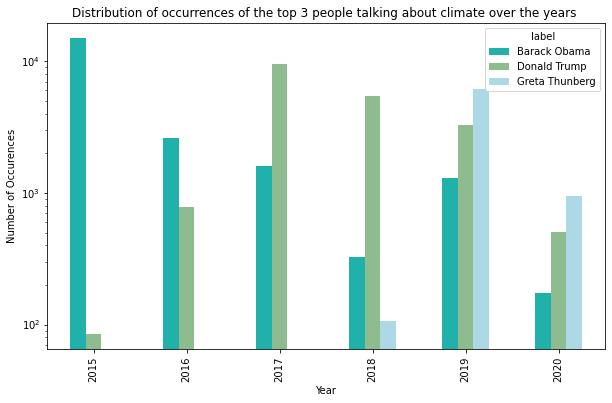

In [53]:
#initialize the plot
fig = df_top_speakers[['index','Barack Obama', 
                 'Donald Trump', 'Greta Thunberg']].plot(x='index', kind ='bar', color =['lightseagreen', 'darkseagreen', 'lightblue'], figsize=(10,6))


#plot settings
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Number of Occurences')
plt.title('Distribution of occurrences of the top 3 people talking about climate over the years ')
plt.show()

### *Interpretation* : 

### Top Quotes
 We extracted quotes with the maximum number of occurrences from each of the top 10 speakers of each year and visualized it. This allows us to observe **which ideas are most mediated**.

In [55]:
for key, value in top_10.items(): 
    
    print('Most mediated sentence from the top 10 speakers for year ' + key)
    print('\n')
    
    for index, row in value.iterrows():
        year=literal_eval(key)
        #extracted quotation over year 
        
        print(row['label'] + ' : ' + dico_clean[year].loc[dico_clean[year][dico_clean[year]['qids'].apply(lambda x: str(x) == ("['" + str(index) + "']"))].numOccurrences.idxmax(), 'quotation'])    
    print('\n')

Most mediated sentence from the top 10 speakers for year 2015


Barack Obama : Climate change is not a problem for another generation,
Ban Ki-moon : The Paris Agreement on climate change is a monumental success for the planet and its people.
Bill Shorten : It's a real shame Malcolm Turnbull is following his party on climate change, not leading it,
Greg Hunt : We now need to find out how much blue carbon can be stored by these ecosystems and how this can contribute to emissions reductions,
Francis : Accepting the urgency, it seems clear to me, also, that climate change is a problem which can no longer be left to a future generation,
Narendra Modi : The prosperous still have a strong carbon footprint... [ while ] the countries at the bottom of the development ladder are seeking space to grow,
François Hollande : What is at stake with this climate conference is peace,
Bernie Sanders : climate change is directly related to the growth of terrorism,
Malcolm Turnbull : What we want from Paris

### *Interpretation :*

As you can see, the quotes address the theme of climate in a diverse and varied way, so we decided that it would be interesting to measure the emotion of our different quotes via Vader Analysis.

### General Intepreation :

# Sentiment Analysis

### *What is the main sentiment communicated in the media over time concerning the climate crisis ?*

In [13]:
#intiliaze the seed
seed = 42
random.seed(seed)
np.random.seed(seed)

In [14]:
analyzer = SentimentIntensityAnalyzer() #declaration of the sentiment analysis function

In [15]:
dico_quotes = {} #dictionnary associated only the quotes from the clean quotes dictionnary

for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico_quotes[date] = dico_clean[date]['quotation']

## Positive and negative rates of the quotes over time

> #### *Calculation of negative and positive ration of climate quotation*

In [16]:
positive_sent = {}
negative_sent = {}

positive_quotes = {}
negative_quotes = {}

#iterate through the sentencs, get polarity scores, choose a value
#we kept only the positive and negative sentiments

for key, quotes_ in dico_quotes.items():
    ls_pos = []
    ls_neg = []
    for quote in quotes_: 
        pos = analyzer.polarity_scores(quote)['pos']
        neg = analyzer.polarity_scores(quote)['neg']
        ls_pos.append(pos)
        ls_neg.append(neg)
        positive_quotes[pos] = quote
        negative_quotes[neg] = quote
    
    positive_sent[key] = ls_pos
    negative_sent[key] = ls_neg

In [17]:
def get_above_zero(my_list): #function to remove the feeling rates that equal exactly to zero as they were outliers
    np_arr = np.array(my_list)
    return np_arr[np_arr > 0]

In [18]:
def get_under_n(my_list,n): #function to remove the feeling rates that equal exactly to zero as they were outliers
    np_arr = np.array(my_list)
    return np_arr[np_arr < 0.45]

> #### *Plot the proportion of positive and negative quotes among all the climate-related quotes for each year*

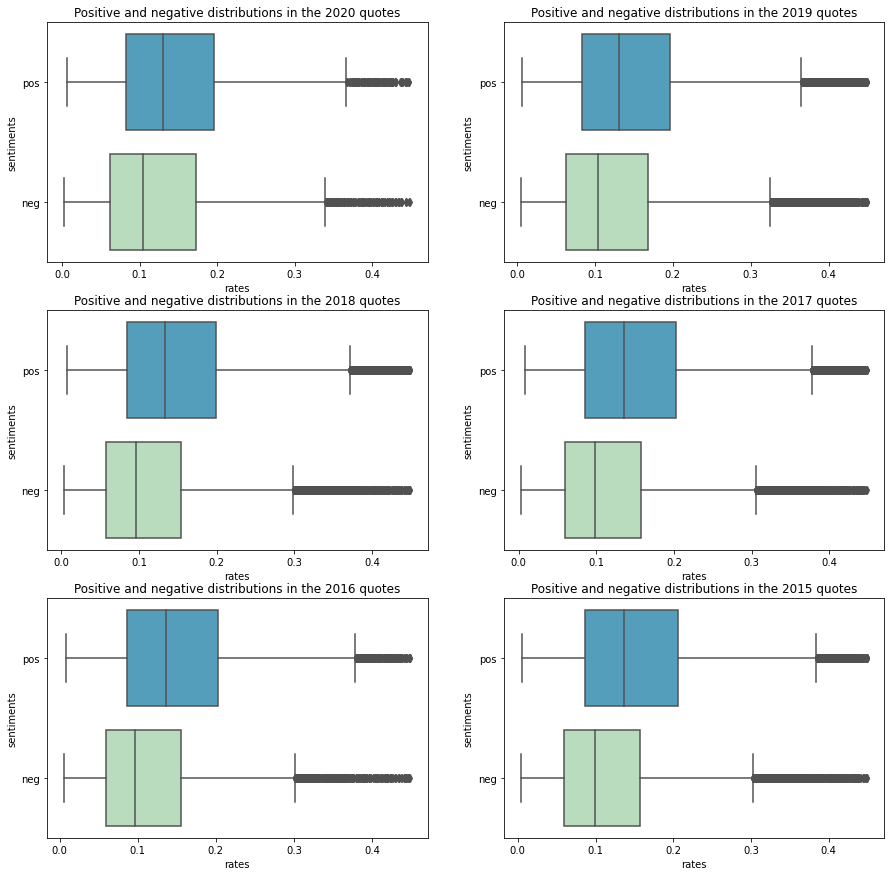

In [19]:
#plotting positive and negative sentiment rates of the quotes across time
fig, axes = plt.subplots(3,2, figsize=(15,15))

palette = sns.color_palette("GnBu", n_colors=2)
palette.reverse()

for idx, date in enumerate([2020, 2019, 2018, 2017, 2016, 2015]):

    ls_pos = get_above_zero(positive_sent[date])
    ls_neg = get_above_zero(negative_sent[date])
    #we decided to removed the values over 0.45 as we considered them as outliers 
    ls_pos = get_under_n(ls_pos,0.45)
    ls_neg = get_under_n(ls_neg,0.45)
    line, col = divmod(idx, 2)
    sns.boxplot(data = [ls_pos,ls_neg], orient = "h", ax = axes[line,col],showfliers=True, palette = palette).set(title = f'Positive and negative distributions in the {date} quotes', xlabel='rates', ylabel='sentiments')
    axes[line,col].set_yticklabels(['pos','neg'])

 We can observe that the general feeling is overall more positive then negative. We also see more extreme value for the negative feeling in 2020 than in 2015. This could be due to the climate emergency that is taking more and more space in people's mind and, consequently, in the media. On the contrary, the positive rate has more extreme values in 2015 than in 2020.

We can also have a more precise visualization by printing the 10 quotes with the highest sentiment rates.

 > #### *Extractaction of quotes with the highest rate*

In [20]:
 #this function returns a list with the 10 highest rate of the dico
def get_highest_rates(dico): 
    ls = {}
    for key,rates in dico.items():
        ls[key] = sorted(rates,reverse=True)[:10]
    return ls

In [21]:
#this dico returns and prints a list of quotations that have the highest rates
def print_quotes_highest_rate(dico_sent,dico_quotes,string): 
    ls_quotes = []
    for key,rate in get_highest_rates(dico_sent).items():
        print('In {} these are the highest {} rate quotes: \n '.format(key,string))
        i=1
        for r in rate: 
            print('{}) {}'.format(i, dico_quotes[r]))
            ls_quotes.append(dico_quotes[r])
            i=1+i
        print('\n ') 
    return ls_quotes

In [22]:
#two lists of quotes for each sentiments
ls_pos = print_quotes_highest_rate(positive_sent,positive_quotes,'positive')   
ls_neg = print_quotes_highest_rate(negative_sent,negative_quotes,'negative')  

In 2020 these are the highest positive rate quotes: 
 
1) a meaningful, universal climate agreement.
2) Love this team. Thanks for the warming messages.
3) welcome is a lot warmer
4) Being in a warm climate certainly helps.
5) climate action causes increased growth.
6) vision for the responsible use of Colorado's significant natural gas resources
7) tackling climate change and clean energy.
8) Climate change is a fantastic opportunity to bring in the market new green technologies that save energy, save natural resources of our planet, make profit, create jobs, and sustain growth,
9) It was heart warming to see then,
10) They are raising issues, certainly around climate change, of great importance,

 
In 2019 these are the highest positive rate quotes: 
 
1) strong supporter of natural gas drilling
2) strong call for climate justice
3) climate of trust and confidence.
4) honest and ambitious carbon price
5) Yes. That's the climate justice.
6) flattering, warming and confidence-boosting


> #### *Wordcloud composed of the 10th frequent words from quotes with the highest rate*

In [48]:
#function to return the 10 main words for each sentiments
def main_words(ls):

    ls_words =[]
    word_pos = []

    for l in ls:
        
        for word in wordpunct_tokenize(l):
            if word not in set(stopwords.words('english')) and not(word == ',') and not (word == '.') and not (word == '!') and not (word == "'") and not (word == "-"):
                ls_words.append(word)  #keep only the significant word 
                
    word_pos = FreqDist(ls_words).most_common(10) #frequences calculation
    return  word_pos

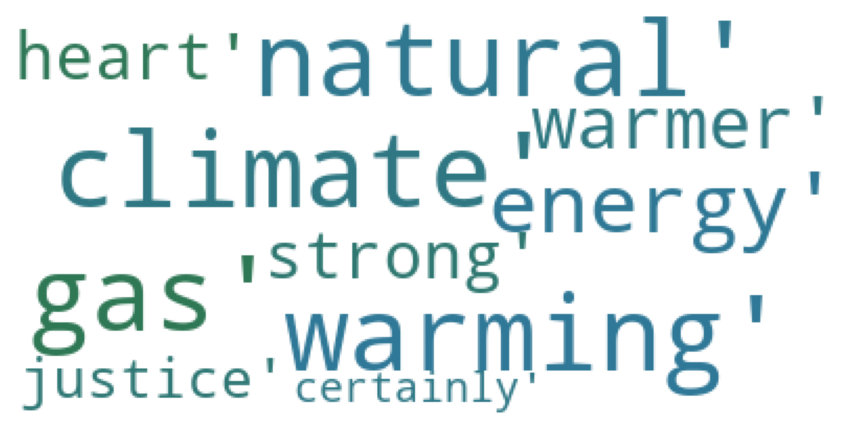

In [49]:
#initialize the wordcloud
wordcloud = WordCloud(max_font_size=50, contour_width=3, background_color='white' ).generate(str(main_words(ls_pos)))


# Display the generated image:
def couleur(*args, **kwargs):
    import random
    return "rgb(47, 120, {})".format(random.randint(60, 170))


#plot settings
fig = plt.figure(figsize=(15,15))
plt.imshow(wordcloud.recolor(color_func = couleur))
plt.axis("off")
plt.show();

#save the figure
fig.savefig('image/positive_quotes.png')

We can clearly observe a positive vibe from this cloud of words.

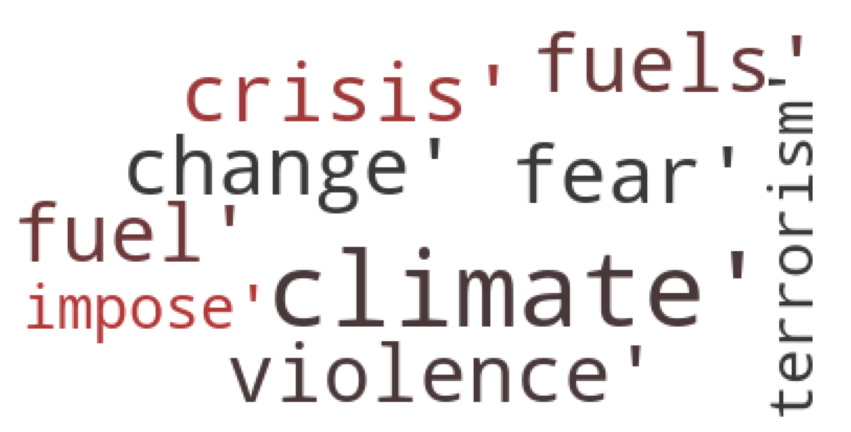

In [25]:
#initialize the wordcloud
wordcloud = WordCloud(max_font_size=50, contour_width=3, background_color='white' ).generate(str(main_words(ls_neg)))

# Display the generated image:

def couleur(*args, **kwargs):
    import random
    return "rgb({},56,57)".format(random.randint(50, 180))


#plot settings
fig = plt.figure(figsize=(15,15))
plt.imshow(wordcloud.recolor(color_func = couleur))
plt.axis("off")
plt.show();

#save the figure
fig.savefig('image/negative_quotes.png')

We can clearly observe a negative vibe from this cloud of words.

## Democratic vs Republican

While looking at the main profiles that talk about climate in the section above, we realised that the two major political parties in the US are the two most represented in the climate-related mediatic speech. As they are opponents of each other and knowing the propensity of the Republicans to doubt about the climate crisis, we would expect the democratic party to be more aware and concerned by climate change than republicans (2021 Chicago Council Survey). We have then looked at the general feeling in the quotes from Republicans versus Democrates.

In [50]:
def quotes_from_id(list): #this function keeps the lines from subdata that contain elements from the list 
    template=[] 
    for n in list: 
        template.append(quotes.loc[(quotes["qids"].apply(lambda x : n in str(x)))])
    return pd.concat(template, ignore_index=True)# return a dataframe with our data of interest

In [51]:
def quotes_sentiments(list): #this function returns two lists for positive and negative sentiments rates
    ls_pos = []
    ls_neg = []
    for n in list: 
        ls_pos.append(analyzer.polarity_scores(n)['pos'])
        ls_neg.append(analyzer.polarity_scores(n)['neg'])
        
    return ls_pos,ls_neg      

In [46]:
#we keep the lines of people that are in the parties of interest 
republican_climate = speakers[(speakers['climate']==1) & (speakers['party'].apply(lambda x : str(x) == "['Republican Party']"))]
democratic_climate = speakers[(speakers['climate']==1) & (speakers['party'].apply(lambda x : str(x) == "['Democratic Party']"))]

In [58]:
#df containing our quotes with respect of the id loaded above 
df_repu = quotes_from_id(republican_climate['id'])
df_demo = quotes_from_id(democratic_climate['id'])

In [59]:
#lists with our sentiment rates
ls_pos_rep, ls_neg_rep = quotes_sentiments(df_repu['quotation'])
ls_pos_dem, ls_neg_dem = quotes_sentiments(df_demo['quotation'])

[Text(0, 0, 'rep'), Text(0, 1, 'dem')]

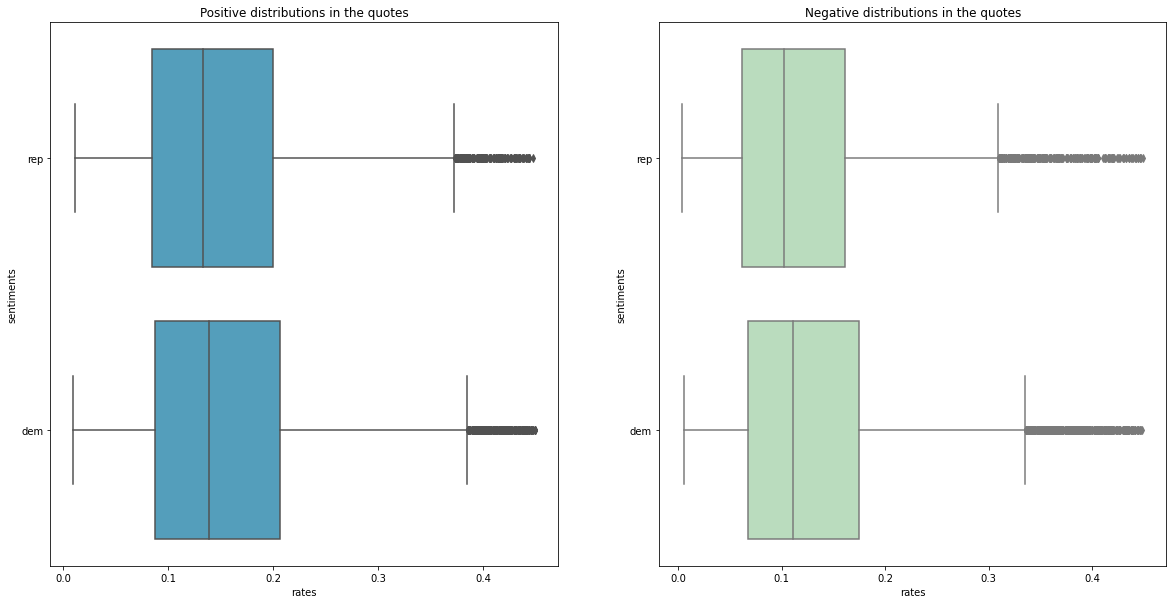

In [60]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

#we will remove outliers above 0.45
palette = sns.color_palette("GnBu", n_colors=2)
palette.reverse()

to_plot = [get_under_n(get_above_zero(ls_pos_rep),0.45),get_under_n(get_above_zero(ls_pos_dem),0.45)]
sns.boxplot(data = to_plot, orient = "h", ax = axes[0], color = palette[0]).set(title = 'Positive distributions in the quotes', xlabel='rates', ylabel='sentiments')
axes[0].set_yticklabels(['rep','dem'], fontsize=10)


to_plot = [get_under_n(get_above_zero(ls_neg_rep),0.45),get_under_n(get_above_zero(ls_neg_dem),0.45)]
sns.boxplot(data = to_plot, orient = "h", ax = axes[1], color = palette[1]).set(title = 'Negative distributions in the quotes', xlabel='rates', ylabel='sentiments')
axes[1].set_yticklabels(['rep','dem'], fontsize=10)

We can observe that the two distribution of sentiment for Republican and Democtatic party are close, let's test if their differences is statistically different.

>#### *T-test for Republican and Democratic party sentimental distribution*

In [ ]:
#print the mean and the variance of the given list 
def print_var_and_mean(ls,string):
    print('The mean and variance for {} are respectively: {} and {} \n'.format(string,np.mean(ls),np.var(ls)))

In [ ]:
#the mean and variance for the lists of positive and negative rates
print_var_and_mean(ls_pos_rep,'positive rates of republicans')
print_var_and_mean(ls_pos_dem,'positive rates of democrats')
print_var_and_mean(ls_neg_rep,'negative rates of republicans')
print_var_and_mean(ls_neg_rep,'negative rates of democrats')


print(stats.ttest_ind(ls_pos_rep, ls_pos_dem))
print(stats.ttest_ind(ls_neg_rep, ls_neg_dem))

According to pvalues that are both very small, we can conclude that the two means are significantly different and thus there is a difference between the two populations.Consequently, we can observe the democratic party people have higher rates and this could be explained by a higher investement than the republicans. 

# Classification of Speakers

### *Based on the profile of person talking about climate in the media, can we predict what characteristics will a climate-involved person have in the future ?*

As we observed that some characterstic seems to
Based on the features extracted from the dataframe speakers, we tried to create a prediction model based on logistic regression. First, we separated the one hot data encoded in train and test set. Then we will visualized the baseline model in order to determine which modfications we could apply on our train set. Finally, we did some hypertunning to determine the best prediction model. 

> #### *Methods usefull to visualise the result of our model*

In [62]:
#method to compute the confusion matrix 
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


#method to plot the matrix 
def plot_confusion_matrix(confusion_matrix):
    
    [[TP, FP],[FN, TN]] = confusion_matrix  #define the matrix
    
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]]) #label the boxes of the confusion matrix
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative'])  
    
    return sns.heatmap(df_cm, cmap='GnBu', annot=label, annot_kws={"size": 16}, cbar=False, fmt='') #plot heatmap


#compute the score 
def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    #calculate the precision  (what fraction of positive predictions is true)
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    #calculate the recall (what fraction of positive example are recognized as such)
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan
    
    #harmonic mean of the recall and precision

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [63]:
def accuracy (matrix_confusion) : 
  
 #recover the different performance of the classifier 
    [t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(matrix_confusion)
    
 #print them 

    print("The accuracy of this model is {0:1.3f}".format(accuracy))
    print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_positive, recall_positive, F1_score_positive))
    print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_negative, recall_negative, F1_score_negative))
    

In [123]:
def features_imp (train_f, params) :
    
    tmp = []
    for name, value in zip(train_f, params):
        tmp.append({"name": name, "value": value}) #concatenate value and names of the features

    features_coef = pd.DataFrame(tmp).sort_values("value")
    features_coef.head() # visualise first coefficient
    

    palette = sns.color_palette("GnBu", n_colors=90)
    palette.reverse()
    
    plt.subplots(figsize=(20,10))
    plt.title('Coefficient weight features in the model')
    #plot features_names and their relative importance into the model
    ax = sns.barplot(x= features_coef.name, y=features_coef.value, palette=palette) 
    ax.set_xticklabels(features_coef.name,rotation=90)

## Data preparation

We recovered the one hot encoding data and separate it to train and test set to performs our classification for climate.

In [73]:
data_original = pd.read_csv("data/one_hot.bz2", compression = 'bz2') #load the data one hot encoding

In [74]:
data = data_original.drop(['label'], axis=1).copy() #drop the label column
data.head(3)

,date_of_birth,climate,politician,association football player,actor,writer,journalist,singer,university teacher,painter,...,cisgender male,agender,male organism,two-spirit,bigender,transmasculine,neutral sex,X-gender,third gender,muxe
0,1952,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1946,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1945,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


*preparation of our features*

In [75]:
X = data.drop(['climate'],axis=1)
y = data['climate']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #split data into train and test set 

## Baseline model

Now we create a “baseline” for logistic classifier with stochastic gradient. This model uses all of the unmodified features and the default settings defined in the Scikit-learn logistic regression documentation. Basline model are simple model that are less likely to overfit and likely to be interpretable. it can helps us to get a better view on our data and show us a direction for the feature engineering. Moreover, comparaison between baseline and engineered model will helps us to conclude about our classification. 

The accuracy of this model is 0.983
For the positive case, the precision is 0.239, the recall is 0.001 and the F1 score is 0.002
For the negative case, the precision is 0.983, the recall is 1.000 and the F1 score is 0.991


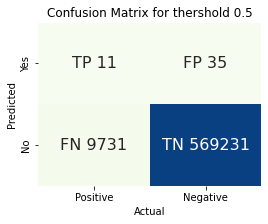

In [77]:
logistic_baseline=LogisticRegression(max_iter = 1000) #we indicate this parameters otherwise the model does not converge
logistic_baseline.fit(X_train, y_train)

prediction_proba_baseline=logistic_baseline.predict_proba(X_test) 
    
#construct the confusion matrix
confusion_matrix_05_baseline = compute_confusion_matrix(y_test, prediction_proba_baseline, 0.5)

plt.figure(figsize = (4,3))   
ax = plot_confusion_matrix(confusion_matrix_05_baseline)

#setting axis
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.set(title = 'Confusion Matrix for thershold 0.5')
    
#get the accuracy of the model
accuracy (confusion_matrix_05_baseline)

 As we can observe above, the accuracy is good as it is close to one. Indeed the accuracy defines the number of corrected classified values divided by the total number of prediction. Here we have an accuracy of 98,3%, which is pretty high. 

- For the positive case, we observe a precision of 0.204, meaning we have a very low number of climate classifications that are correctly classified. The recall represents the fraction of climate classification that our model recognize as such, here it is  equal to 0.001. Overall, we have a score of 0.002, this means our model does not predict our climate speaking people.

- For the negative case, we observe a precision of 0.983, meaning we have a very high number of non climate classifications that are correctly classified. The recall is  equal to 1, meaning 100% of our non climate speakers were recognized as such. Overall, we have a score of 0.991, this means our model does not predict our climate speaking people.

For now our model is a good predictor only for non climate speaker, but doesn't predict climate speaking people

In [ ]:
features_imp (X_train.columns, logistic_baseline.coef_[0])

Based on the baselin model we can observe that our data is largely imbalanced : the classifier tend to alway predict 0 for climate and still get an amazing accarucy ! However, if we take a look at the F-score for positive case, we can observe that it is null... In fact, climate speakers are in minority in our data and so we need to modify our training set to get a satisfy classification. 

## Modification of the train set

> #### *undersampling*

In [91]:
print('We have {} speakers talking about climate'.format(len(data[data['climate']==1])))
print('We have {} speakers that do not talking about climate'.format(len(data[data['climate']==0])))

We have 48722 speakers talking about climate
We have 2846314 speakers that do not talking about climate


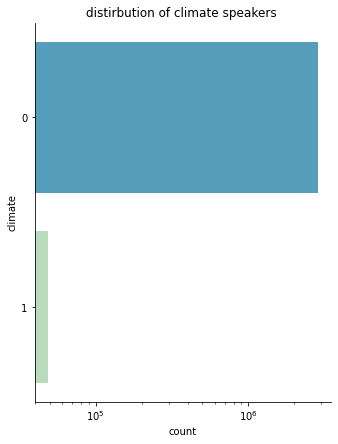

In [92]:
palette = sns.color_palette("GnBu", n_colors=2)
palette.reverse()



ax = sns.catplot(y="climate", data=data,
                kind="count", height=6, aspect=.8, palette=palette)
ax.set(xscale='log', title = 'distirbution of climate speakers ')
plt.show()

As we can see we have an  imbalanced datasets examples where climate speakers are in the minority class. This distribution cause bias in the training dataset and can influence our classification leading some to ignore the minority class entirely. We decided to manage this problem by randomly resampling the training dataset. The two main approaches are to delete examples from the majority class, called undersampling, and to duplicate examples from the minority class, called oversampling. In frame with the dimension of our dataset we decided to go with undersamplig.

In [93]:
undersample = RandomUnderSampler(sampling_strategy=0.5) #stategy = 0,5, majority class yill be the same amount as the minority class (1 to 1)

# fit and apply the transform into the train set
X_smote, y_smote = undersample.fit_resample(X_train, y_train)

In [126]:
print('Before undersampling we get {} non climate outcomes, after undersampling we get {} climates outcome'.format(y_train.value_counts()[0], y_smote.value_counts()[0]))

Before undersampling we get 2277048 non climate outcomes, after undersampling we get 77960 climates outcome


As we get a large number of features, dimensionality reduction could be an option, let's visualize the variance explained by each feature in order to select an interval containing the major components for the PCA 

> #### *PCA on training set*

In [95]:
#scale our dataset : Standardize features by removing the mean and scaling to unit variance.
scaler=StandardScaler()
scaler.fit(X_smote)
train_scaled = pd.DataFrame(scaler.transform(X_smote), columns=X_smote.columns) 
test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns) 

In [ ]:
pca = PCA().fit(train_scaled)


plt.plot(np.cumsum(pca.explained_variance_ratio_), color = 'lightblue')



#plot parameters 

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.axhline(y=0.8, color='lightseagreen', linestyle='-')
plt.text(0.5, 0.88, '80% cut-off threshold', color = 'lightseagreen', fontsize=16)
plt.xticks(np.arange(0, 142, step=5), rotation=90)
plt.grid(axis='x')
plt.show()

In [97]:
#Creation of Dataframe containing the major components
evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(100))

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.017831,0.017831
1,0.032845,0.015014
2,0.047571,0.014725
3,0.061130,0.013559
4,0.073483,0.012353
...,...,...
95,0.802651,0.006861
96,0.809496,0.006845
97,0.816223,0.006728
98,0.822907,0.006683


Based on the graph we can see that each component does not have a great explained variance (<<0.02...), it seems that components bewteen 95 and 100 are required to explained at least 80% of the variance. Even if the variance explained does not seems sufficient, we will try to test PCA on ours features and check if it improves our predicions.

## Logistic Regression

Logistic regression measures the relationship between variable by estimating probabilities using a logistic function.
One thing we may want to do is rescale the features/inputs. Rescaling data brings values that may have extremely different ranges or units into alignment with one another. Bringing all the measurements into a similar scale helps the performance of the classifier (for a comparison try dropping the scaling and see how your performance decreases), and we can accomplish this with the StandardScaler from sklearn library. Another idea as already mention is to test for PCA.

> #### *without  scaling and PCA*

In [307]:
#declaration of a pipe flow

pipe = Pipeline([('logistic',LogisticRegression())])
    

# pipe flow is : logistic regression


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs']
max_iter=[100, 1000, 10000]
C = [0.001,0.01,  0.1, 1, 10, 100] 


# make lists of different parameters to check
param_grid = dict(logistic__penalty=penalty,
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 



    
# initialization
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
    
#fit
grid_result = grid.fit(X_smote, y_smote) 
    
#print score and params of the best model
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.7978979925767409
Best Params:  {'logistic__C': 1, 'logistic__max_iter': 1000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}


> #### *standarized without PCA* 

In [308]:
#declaration of a pipe flow

pipe = Pipeline([('std_slc', StandardScaler()),  
                 ('logistic',LogisticRegression()), ]
                 )
    
    
# pipe flow is :
#  Scaling the data -> Logistic regression


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs']
max_iter=[100, 1000, 10000]
C = [0.001,0.01,  0.1, 1, 10, 100] 


# make lists of different parameters to check
param_grid = dict(logistic__penalty=penalty,
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 



    
# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
    
#fit
grid_result = grid.fit(X_smote, y_smote) 
    
#print score and params of the best model
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_) 
print('Best Params: ', grid_result.best_params_) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.8164649087256072
Best Params:  {'logistic__C': 1, 'logistic__max_iter': 100, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Best Params:  {'logistic__C': 1, 'logistic__max_iter': 100, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}


> #### *With PCA*

In [309]:
#declaration of a pipe flow
pipe = Pipeline([('std_slc', StandardScaler()),
                ('pca', PCA()),
                ('logistic',LogisticRegression())])
    
    
# pipe flow is :
# PCA(Dimension reduction test for 95 or 100) -> Scaling the data -> logistic regression


#different parameters for hypertunning
n_components=[95, 100]
penalty = ['l2'] 
solver=['lbfgs']
max_iter=[100, 1000, 10000]
C = [0.001, 0.1, 1, 10, 100]


# make lists of different parameters to check
param_grid = dict(pca__n_components=n_components, logistic__penalty=penalty, 
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 



    
# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv =5) 
    
#fit
grid_result = grid.fit(X_smote, y_smote) 
    
#print score and params of the best model
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Score:  0.8062879498267914
Best Params:  {'logistic__C': 0.1, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs', 'pca__n_components': 100}


==> We can see that the **second model** returns the best accuracy: let's use it for our classification. 

### General Classificaion

The accuracy of this model is 0.861
For the positive case, the precision is 0.072, the recall is 0.606 and the F1 score is 0.128
For the negative case, the precision is 0.992, the recall is 0.865 and the F1 score is 0.925


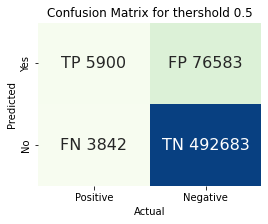

In [98]:
logistic=LogisticRegression(solver ='lbfgs', penalty = 'l2', C=0.1, max_iter=100)
logistic.fit(train_scaled, y_smote)

prediction_proba=logistic.predict_proba(test_scaled) 
    
#construct the confusion matrix
confusion_matrix_05_model = compute_confusion_matrix(y_test, prediction_proba, 0.5)

plt.figure(figsize = (4,3))   
ax = plot_confusion_matrix(confusion_matrix_05_model)

#setting axis
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.set(title = 'Confusion Matrix for thershold 0.5')
    
#get the accuracy of the model
accuracy (confusion_matrix_05_model)
    

As we can observe above, the accuracy is good as it is close to one, but not as good as for the baseline. Here we have an accuracy of 86% wheras for the baseline we had 98,3%. 

- For the positive case we have better results here than for the baseline, but it is still close to zero. Only 7,2% of our climate positive classification are correctly classified. The recall here is way better than above, suggesting we have a higher positive climate classification that our model recognize as such. Overall, we have a score of 0.128 compare to 0.002 for the baseline, this means our model does not predict well our climate speaking people, but our model improved.

- For the negative case, we observe high precision, recall and score values. Meaning again, the climate negative speaker were classified with a good accuracy.

Our model is performing better for the recall, thus a higher rate of climate positive classification are well classified, but a small fraction of positive classified are actually correctly classified

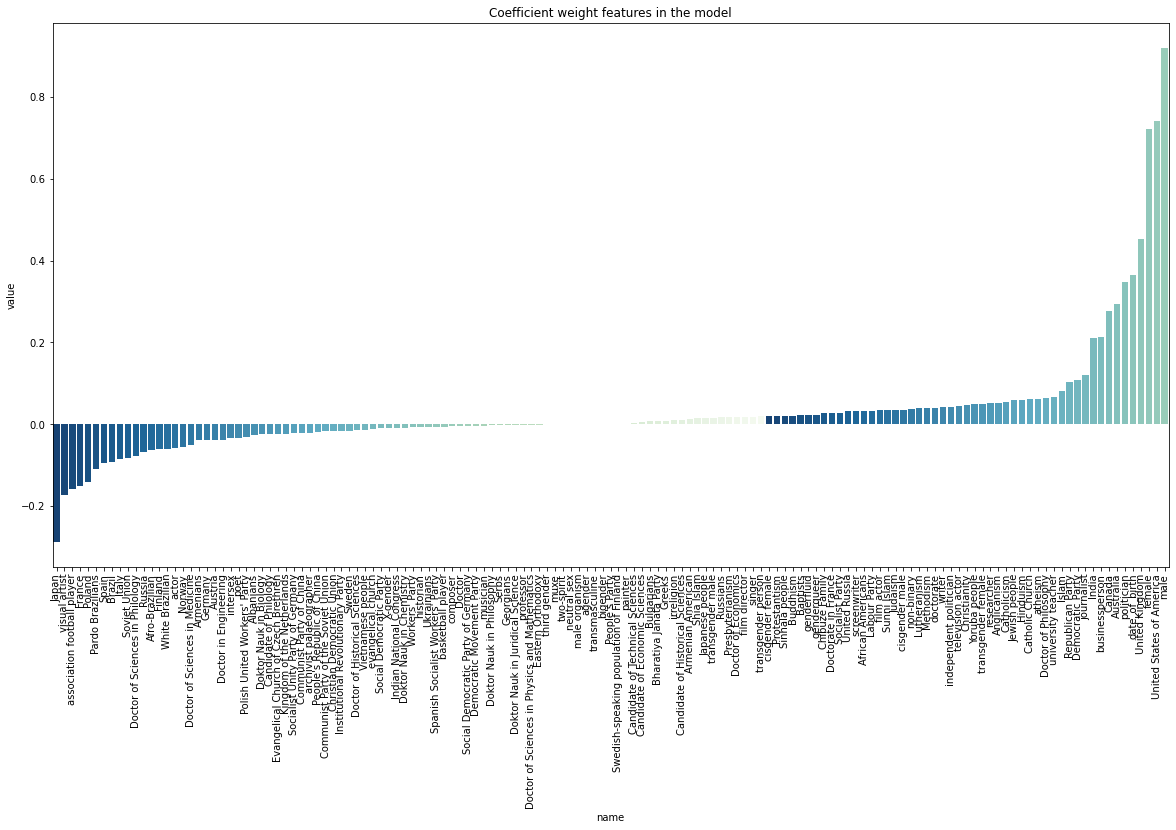

In [124]:
features_imp (train_scaled, logistic.coef_[0])

As we get a lot of features, we decided to test if by taking the most significant features from the previous model we can get a better classification.

###  Classification after selecting the most important features

In [110]:
sub_features_train=train_scaled.iloc[:,np.where(logistic.coef_[0]>0.015)[0]]
sub_features_test =test_scaled.iloc[:,np.where(logistic.coef_[0]>0.015)[0]]

The accuracy of this model is 0.862
For the positive case, the precision is 0.071, the recall is 0.599 and the F1 score is 0.127
For the negative case, the precision is 0.992, the recall is 0.867 and the F1 score is 0.925


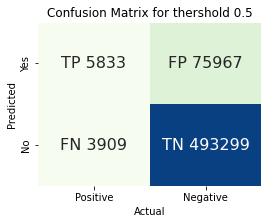

In [113]:
logistic_sub=LogisticRegression(solver ='lbfgs', penalty = 'l2', C=0.1, max_iter=1000)
logistic_sub.fit(sub_features_train, y_smote)

prediction_proba_sub=logistic_sub.predict_proba(sub_features_test) 
    
#construct the confusion matrix
confusion_matrix_05_sub_model = compute_confusion_matrix(y_test, prediction_proba_sub, 0.5)

plt.figure(figsize = (4,3))   
ax = plot_confusion_matrix(confusion_matrix_05_sub_model)

#setting axis
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.set(title = 'Confusion Matrix for thershold 0.5')
    
#get the accuracy of the model
accuracy (confusion_matrix_05_sub_model)

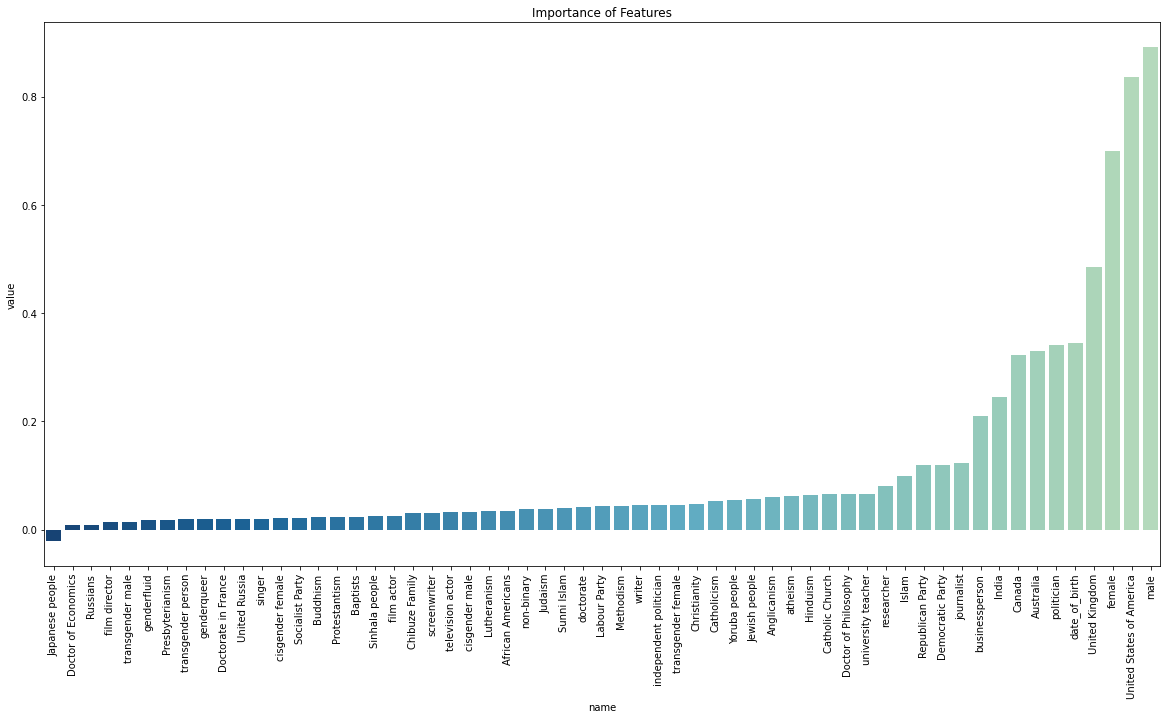

In [114]:
features_imp (sub_features_train.columns, logistic_sub.coef_[0])

#### *Interpretation* : 

### Classification per caracheristic

In [115]:
occupation_train = X_smote.iloc[:, 1:21]
occupation_test = X_test.iloc[:, 1:21]
gender_train = X_smote.iloc[:, 121:141]
gender_test = X_test.iloc[:, 121:141]
nationality_train =X_smote.iloc[:, 61:81]
nationality_test  = X_test.iloc[:, 61:81]
academic_degree_train =X_smote.iloc[:, 101:121]
academic_degree_test  = X_test.iloc[:, 101:121]

In [116]:
dico={'occupation' : [occupation_train, occupation_test], 'gender' : [gender_train,gender_test],  
      'nationality ':[nationality_train, nationality_test], 'academic_degree' : [academic_degree_train, academic_degree_test] }

> #### *Hypertunning parameters and test for scaled or non scaled train feature*

In [107]:
#declaration of a pipe flow
pipe = Pipeline([('logistic',LogisticRegression())])
    
    
# pipe flow is :
#  Scaling the data -> SDGClassifier


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs']
max_iter=[10000]
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000] 


# make lists of different parameters to check
param_grid = dict( logistic__penalty=penalty, 
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 




# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
    
#fit
for name, data in dico.items() :
    grid_result = grid.fit(data[0], y_smote)  
    print(f'Best Score for non standarized {name} is: ', grid_result.best_score_) 
    print(f'Best Params for non standarized {name} is : ', grid_result.best_params_) 

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for non standarized occupation is:  0.6307814599045807
Best Params for non standarized occupation is :  {'logistic__C': 0.01, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for non standarized gender is:  0.5412110142655151
Best Params for non standarized gender is :  {'logistic__C': 1000, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for non standarized nationality  is:  0.5151049779576744
Best Params for non standarized nationality  is :  {'logistic__C': 1, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for non standarized academic_degree is:  0.5059114082395071
Best Params for non standarize

In [108]:
#declaration of a pipe flow
pipe = Pipeline([('std_slc', StandardScaler()),
                ('logistic',LogisticRegression())])
    
    
# pipe flow is :
# Scaling the data -> Logistic regression


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs', 'sag']
max_iter=[10000]
C = [0.001, 0.01, 0.1, 1, 10, 100] 


# make lists of different parameters to check
param_grid = dict( logistic__penalty=penalty, 
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 




    
# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
#fit
for name, data in dico.items() :
    grid_result = grid.fit(data[0], y_smote)  
    print(f'Best Score for  standarized {name} is : ', grid_result.best_score_) 
    print(f'Best Params for  standarized {name} is: ', grid_result.best_params_) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for  standarized occupation is :  0.6306644431397244
Best Params for  standarized occupation is:  {'logistic__C': 0.001, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for  standarized gender is :  0.5412397008135363
Best Params for  standarized gender is:  {'logistic__C': 0.001, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for  standarized nationality  is :  0.5151046785053234
Best Params for  standarized nationality  is:  {'logistic__C': 0.01, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'sag'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for  standarized academic_degree is :  0.5058858560691161
Best Params for  standarized academic_degre

> ### *Let's see the result !*

for occupation categories we obtained : 

The accuracy of this model is 0.877
For the positive case, the precision is 0.042, the recall is 0.286 and the F1 score is 0.073
For the negative case, the precision is 0.986, the recall is 0.887 and the F1 score is 0.934


for gender categories we obtained : 

The accuracy of this model is 0.983
For the positive case, the precision is 0.060, the recall is 0.002 and the F1 score is 0.003
For the negative case, the precision is 0.983, the recall is 1.000 and the F1 score is 0.991


for nationality  categories we obtained : 

The accuracy of this model is 0.978
For the positive case, the precision is 0.077, the recall is 0.026 and the F1 score is 0.039
For the negative case, the precision is 0.984, the recall is 0.995 and the F1 score is 0.989


for academic_degree categories we obtained : 

The accuracy of this model is 0.982
For the positive case, the precision is 0.071, the recall is 0.006 and the F1 score is 0.011
For the negative case, the p

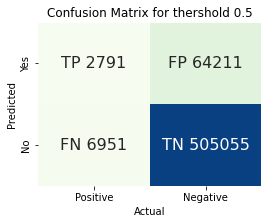

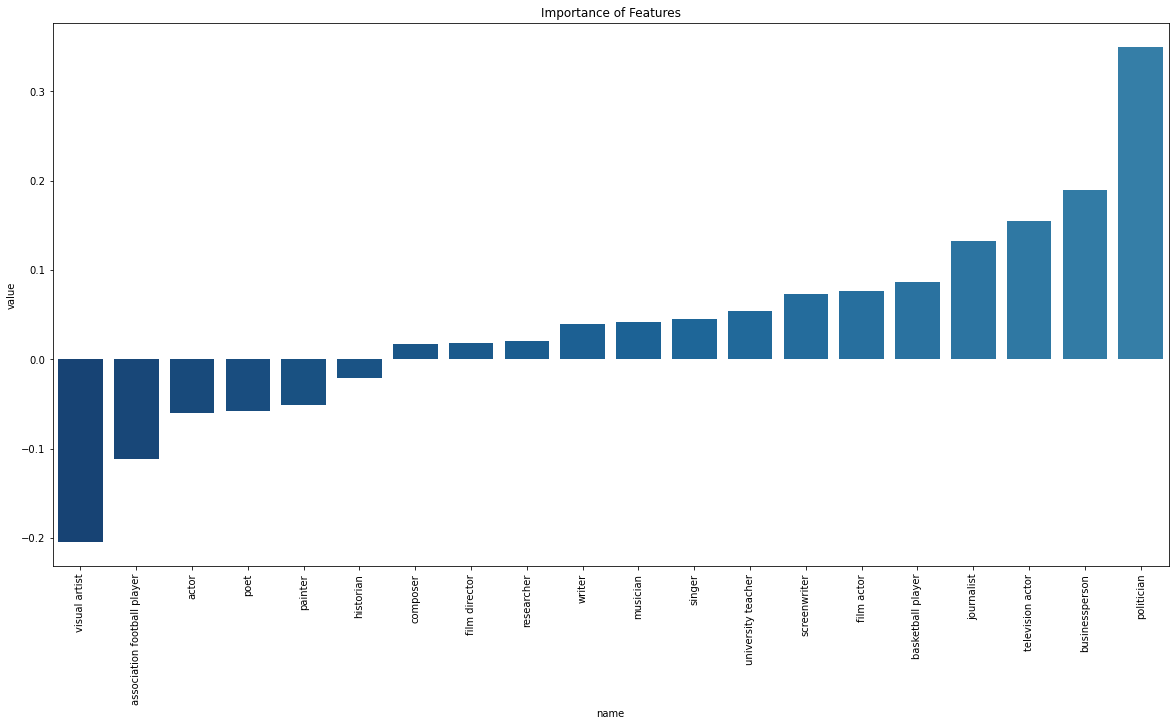

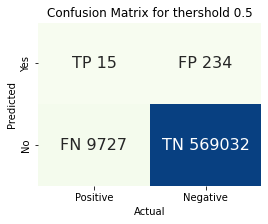

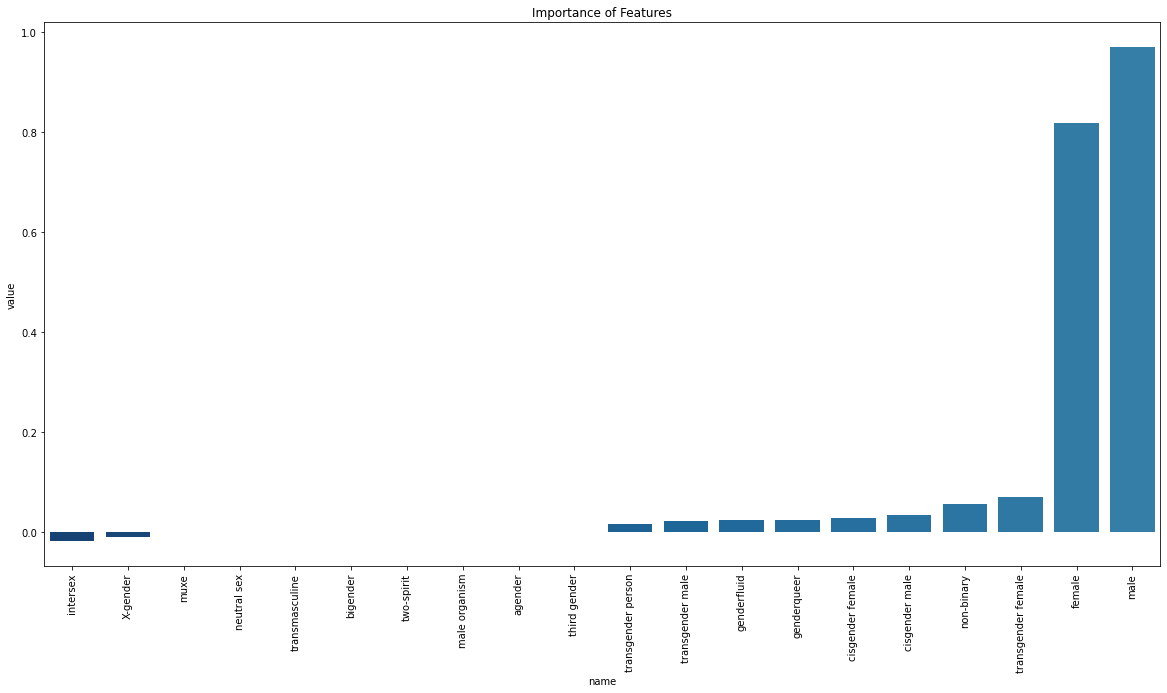

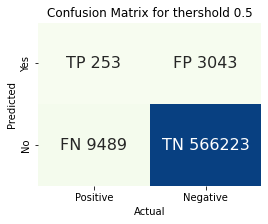

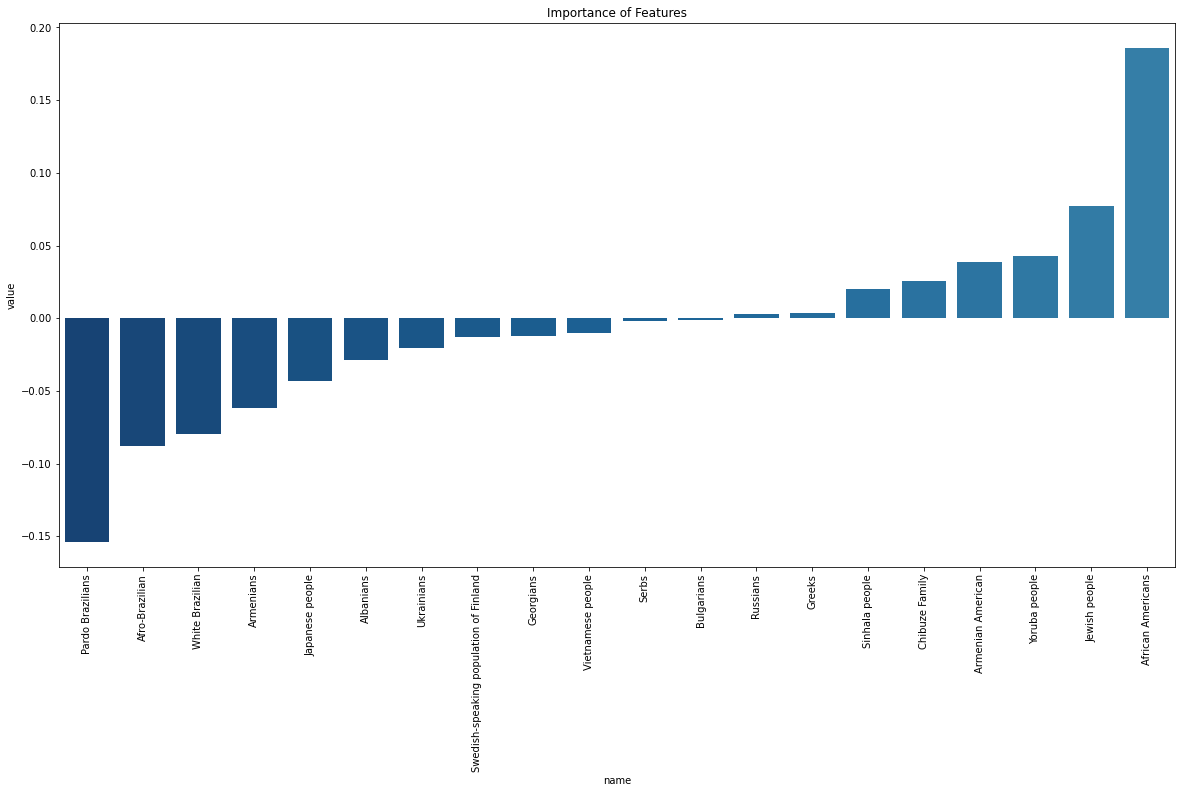

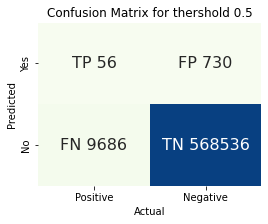

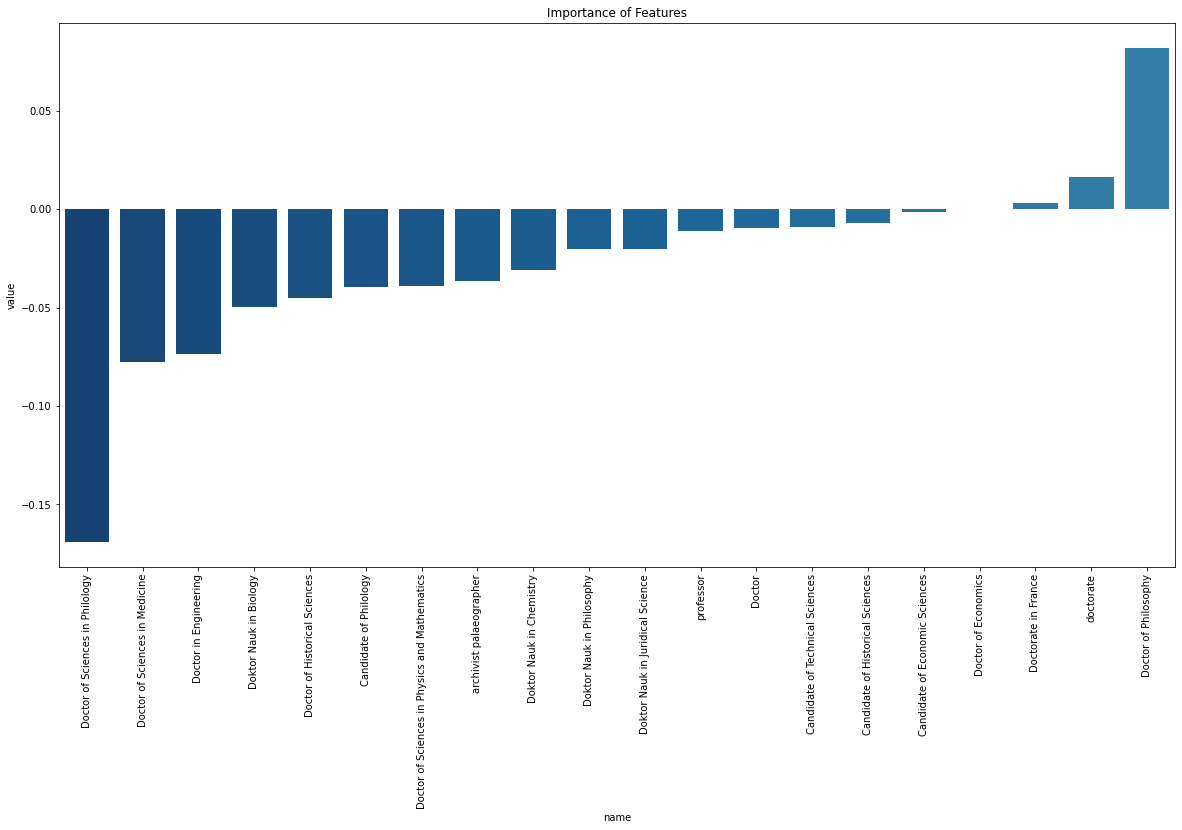

In [120]:
C=[0.01, 0.01, 1, 100]

i=0
for name, data in dico.items() :
    
    scaler=StandardScaler()
    scaler.fit(data[0])
    
  
    train_scaled_ = pd.DataFrame(scaler.transform(data[0]), columns=data[0].columns) 
    test_scaled_ = pd.DataFrame(scaler.transform(data[1]), columns=data[1].columns) 
    
   
    
    logistic_categories=LogisticRegression(solver ='lbfgs', penalty = 'l2', C=C[i], max_iter=10000)
    logistic_categories.fit(train_scaled_, y_smote)
    prediction_proba_categories=logistic_categories.predict_proba(test_scaled_) 
    
    
    #construct the confusion matrix
    confusion_matrix_05_sub_cat = compute_confusion_matrix(y_test, prediction_proba_categories, 0.5)
    plt.figure(figsize = (4,3))   
    ax = plot_confusion_matrix(confusion_matrix_05_sub_cat)
    #setting axis
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    ax.set(title = 'Confusion Matrix for thershold 0.5')
    #get the accuracy of the model
    print(f'for {name} categories we obtained : \n')
    accuracy (confusion_matrix_05_sub_cat)
    features_imp (train_scaled_.columns, logistic_categories.coef_[0])
    print('\n')
    i+=1
    

#### *Interpretation* : 

## General Conclusion

nsm